# PHYLOGENETIC TREES WITH DIGITAL ANNEALER INSPIRED BY NEIGHBOUR JOINING

The main objective of this method is to consecutively **group** a set of nodes or species with Fujitsu's Digital Annealer until a phylogenetic tree is obtained.

In [ ]:
# local DA imports
from dadk.BinPol import *
from dadk.QUBOSolverCPU import *
from dadk.Solution_SolutionList import *

# real DA imports
from dadk.QUBOSolverDAv3c import *
from dadk.internal.ConnectionParameter import ConnectionParameter
from dadk.ProfileUtils import ProfileUtils
profile = ProfileUtils.get_annealer_access_profile(access_profile_file=r'~/.dadk/profiles/Lantik.prf')
connection_parameter = ConnectionParameter.decode(profile)

# ProfileUtils.list_annealer_access_profiles()
# ProfileUtils.store_annealer_access_profile(name_in_profile_store='Lantik',**profile)

from openpyxl import load_workbook
import networkx as nx
import csv
import numpy as np
import time
import json
from datetime import datetime, timedelta
import enum

## Data collecting

In order to be able to obtain a phylogenetic tree, we need a set of species and a measurement that allows us to determine how close they are to each other. This would constitute the nodes and the edges of the graph we are going to cut. 

For that, we have originally taken datasets from [Phylome DB](https://phylomedb.org/phylomes?s=expl), a database webpage of different phylomes that offers both the standard accepted phylogenetic tree and the amino acid sequences of the species. With this amino acid sequence, in FASTA format, we have used the $\verb|func_cleanfasta|$ to clean up the .fasta files and fed it to BLAST+. The program analyzes its database of aminoacid sequences and following a local comparison algorithm, returns several metrics, among which we find the bit scores. 

Bit scores are a good metric that take several characteristics into account to determine how closely related the two species are. They are not normalized when they first come out of BLAST+, so the first step to get a proper matrix of similarities is to normalize them. Let us see how we do that with the following code.

In [ ]:
# IMPORT SIMILARITY MATRIX (TSV FILE)

def import_from_tsv(filename):

    """
    Imports a similarity matrix from a tsv file and returns a list of nodes and a bitscore matrix.

    Args:
        filename (str): Path to the Excel file.

    Returns:
        nodes (list): List of unique node names.
        bitscore_matrix (numpy.ndarray): 2D numpy array representing the bitscore matrix.
    """

    tsv_path = filename
    column_list = []
    
    # Reads all rows as lists first
    
    with open(tsv_path, newline='', encoding='utf-8') as f:
        reader = csv.reader(f, delimiter='\t')
        rows = list(reader)
    
    # Transpose rows for columns
    
    for col in zip(*rows):
        column_list.append(list(col))
    
    # No header
    
    nodes_query = column_list[0]
    nodes_sub = column_list[1]
    bit_scores = column_list[11]
    
    bit_scores = [float(i) for i in bit_scores]

    # returs nodes and bitscore matrix

    nodes = extract_nodes(nodes_query)
    bitscore_matrix = extract_matrix(nodes_query, nodes_sub, nodes, bit_scores)

    return(nodes, bitscore_matrix)

The reason for $\verb|nodes_query|$ and $\verb|nodes_sub|$ to exist is that BLAST+ first creates a database with our .fasta file and calls the species in that database 'Subject'. Then it iteratively compares the sequences in the original .fasta ('Queries') with the ones on the database, so we have two columns with all the possible pairs in the set. To have a proper array with only the nodes (sequences) for future use, we will search through the first column and get the unique names out of it.

In [ ]:
def extract_nodes(nodes_query):
    """
    Subroutine that extracts unique nodes from the nodes_query list.

    Args:
        nodes_query (list): Original query nodes list.

    Returns:
        nodes (list): List of unique node names.
    """

    nodes = []

    # we initialize the current node selected
    # the nodes are in order, so we just need to check when the name changes
    current_node_name = nodes_query[0]
    nodes.append(current_node_name)
    
    # we inspect all the nodes in nodes_query
    for i in range(len(nodes_query)):
        # select a new node only when the name changes
        if nodes_query[i] != current_node_name:
            nodes.append(nodes_query[i])
            # we update current_node_name
            current_node_name = nodes_query[i]
    
    return(nodes)

Now, we will normalize the bit scores. We will use the formula

$$ Norm_{bit(i,j)} = \frac{bit(i,j)}{\mathrm{mean}\{bit(i,i), bit(j,j)\}}*100. $$



We must also rearrange the $\verb|bit_scores_norm|$ array into a matrix. This is not a trivial step, as the total length of the array is not exactly $nodes \times nodes $, since some species are so distantly related that BLAST+ has purged them out. For those cases, we will asign the default zero to the edge between those nodes.

In [ ]:
def extract_matrix(nodes_query, nodes_sub, nodes, bit_scores):

    """
    Subroutine that builds the structure of the bitscore matrix from the nodes_query and 
    nodes_sub list and the values from the normalized the bit_scores list.

    Args:
        nodes_query (list): List of query nodes.
        nodes_sub (list): List of subject nodes.
        nodes (list): List of unique node names.
        bit_scores (list): List of bit scores.

    Returns:
        bitscore_matrix (numpy.ndarray): 2D numpy array representing the bitscore matrix.
    """

    n_total = len(bit_scores)
    
    bit_scores_norm = []
    
    # We iterate over the entire array of bit scores
    
    for k in range(n_total):
    
        # We save the name of the query and subject
        query_name = nodes_query[k]
        sub_name = nodes_sub[k]
    
        # We iterate over the rest of the list finding the bit(query,query) = bit(i,i)
        # and bit(subject,subject) = bit(j,j)
    
        for i in range(n_total):
            
            if nodes_query[i] == query_name and nodes_sub[i] == query_name:
                bit_i_i = bit_scores[i]
    
            if nodes_query[i] == sub_name and nodes_sub[i] == sub_name:
                bit_j_j = bit_scores[i]
    
        # Calculate the mean
        mean_scores = (bit_i_i + bit_j_j)/2
    
        # Apply formula
        bit_scores_norm.append(bit_scores[k]*100/mean_scores)
        

    ### BIT SCORE MATRIX BUILD ###
    
    bitscore_matrix = np.zeros([len(nodes),len(nodes)])
    
    for k in range(n_total):
    
        # for each element in bit_scores_norm, we search for the corresponding
        # indexes (matching names) in the nodes array, thus we find the
        # corresponding column and row in the matrix
        
        index_query = nodes.index(nodes_query[k])
        index_sub = nodes.index(nodes_sub[k])
        bitscore_matrix[index_query,index_sub] = bit_scores_norm[k]


    ### TRIANGULATION ###
    
    # The matrix must be symmetrical and sometimes it is not symmetrical when it comes
    # directly out of the bitscore list values, so we force the symmetry by 
    # calculating the mean of the corresponding values 
    for i in range(len(nodes)):
        for j in range(len(nodes)):
            
            if bitscore_matrix[i][j] != bitscore_matrix[j][i]:
                # mean between element (i,j) and element (j,i)
                mean_score = (bitscore_matrix[i][j] + bitscore_matrix[j][i])/2
                # reset value of elements (i,j) and (j,i) to the new mean
                bitscore_matrix[i][j] = mean_score
                bitscore_matrix[j][i] = mean_score
    
            # Diag zeros !! NOT DIAG ZEROS THIS TIME
    
            # if i == j:
            #     bitscore_matrix[i][j]= 0

    return(bitscore_matrix)       

We find an interesting result when printing this matrix, which is that it is not exactly symmetrical. This is due to the algorithm that BLAST+ uses to compare queries against subjects. For example, if the amino acid sequence of a certain species is too short, it may yield different results when comparing that species with another as subject-query VS query-subject. In order to fix this, we have decided to triangulate the matrix by taking the mean between the corresponding entries $\mathrm{mean}(\verb|bitscore_matrix[i][j]|, \verb|bitscore_matrix[j][i]|)$.

## NEIGHBOUR JOINING MATRIX

$$
Q(i,j) = (n-2) d(i,j) - \sum_{k=1}^n d(i,k) - \sum_{k=1}^n d(j,k)
$$

In [7]:
def calculate_real_nj(bitscore_inverse):

    N = bitscore_inverse.shape[0]
    real_nj = np.zeros((N, N))

    for i in range(N):
        for j in range(i+1, N):
            real_nj[i,j] = (N-2)*bitscore_inverse[i][j] - np.sum(bitscore_inverse[i,:]) - np.sum(bitscore_inverse[j,:])

    return(real_nj)

## Combined nodes

We first calculate the distances between all the nodes ($\verb|bitscore_matrix|$) and the combined nodes (also refered to as artificial nodes or intermediate nodes). This process is of order $O(n(n-1)/2)$. 

The distance of the rest of the individuals to the combined nodes can be calculated through the Neighbour-Joining formula for the creation of a new node:
$$
d(u,k) = \frac{1}{2} [d(f,k)+d(g,k)-d(f,g)]
$$
where $f$ and $g$ are the joined nodes and $k$ is any other node left. $d(a,b)$ denotes the distance (normalized bitscore) between nodes $a$ and $b$.

In [8]:
def change_index(len_nodes, index_list, n_index=None):
    """
    Change the index of the matrix from (i,j) to the corresponding planar index up to N(N+1)/2
    """ 
    if index_list != []:
        if index_list[1] <= index_list[0]:
            i = index_list[1]
            j = index_list[0]
        else:
            i = index_list[0]
            j = index_list[1]
        n_index = len_nodes + sum([x for x in reversed(range(len_nodes))][:i]) + j - i - 1
        return(n_index)
    elif n_index:
        i = 0
        suma = len_nodes
        while suma+len_nodes-i-1<= n_index:
            i += 1
            suma += len_nodes - i

        j = n_index - suma + i +1 

        return [i,j]


In [9]:
def filter_combined_nodes(len_nodes, nj_matrix, del_comb):
    
    N = len_nodes

    index_list = []

    for k in range(int(N*(N+1)/2)):
        if k < len_nodes:
            index_list.append(k)
        else:
            i_index = change_index(N, [], k)[0]
            j_index = change_index(N, [], k)[1]
            index_list.append((i_index,j_index))

    if N<4:
        return(index_list)

    number_del_nodes = round(del_comb*N*(N-1)/2)
    short_nj_matrix = nj_matrix[:,:len_nodes]

    for k in range(number_del_nodes):
        max_value = short_nj_matrix.max()
        indices = np.argwhere(short_nj_matrix == max_value)
        i_index = int(indices[0][0])
        j_index = int(indices[0][1])
        
        l_index = index_list.index((i_index,j_index))
        index_list.pop(l_index)
        short_nj_matrix[i_index,j_index] = 0

    return(index_list)

In [10]:
def calculate_adj_matrix(bitscore_inverse, comb_index_list):

    N = bitscore_inverse.shape[0]
    N_big = len(comb_index_list)
    adj_matrix = np.zeros((N, N_big))

    for i in range(N):
        for j in range(i+1, N):
            adj_matrix[i,j] = bitscore_inverse[i][j]
            adj_matrix[j,i] = adj_matrix[i,j]

    for item in comb_index_list:
        if isinstance(item, tuple):
            i_index = item[0]
            j_index = item[1]
            n_index = comb_index_list.index(item)
            for k in range(N):
                adj_matrix[k,n_index] = 0.5*(bitscore_inverse[i_index][k] + bitscore_inverse[j_index][k] - bitscore_inverse[i_index][j_index])

    return(adj_matrix)


In [11]:
def correct_nj(nj_matrix):

    N = nj_matrix.shape[0]
    new_nj_matrix = - min(min(row) for row in nj_matrix) + 1 + nj_matrix
    
    for i in range(N):
        for j in range(N):
            if j<= i:
                new_nj_matrix[i][j] = 0

    return(new_nj_matrix)

In [12]:
def calculate_combined_nj(real_nj, adj_matrix, comb_index_list):

    N = real_nj.shape[0]
    N_big = len(comb_index_list)
    combined_nj = np.zeros((N, N_big-N))
    total_nj_matrix = np.concatenate((real_nj, combined_nj), axis=1)

    for item in comb_index_list:

        if isinstance(item,tuple):
            i_index = item[0]
            j_index = item[1]
            n_index = comb_index_list.index(item)
            
            for k in range(N):
                if k==i_index or k==j_index:
                    total_nj_matrix[k, n_index] = 1000
                else:
                    total_nj_matrix[k, n_index] = (N-3)*adj_matrix[k, n_index] - np.sum(adj_matrix[k,:N]) - np.sum(adj_matrix[:,n_index])
                    total_nj_matrix[k, n_index] += - adj_matrix[k][n_index] + adj_matrix[k][i_index] + adj_matrix[k][j_index]

    corrected_nj_matrix = correct_nj(total_nj_matrix)

    return(corrected_nj_matrix)

In [13]:
def main_calculate_nj(adj_matrix, del_comb):

    N = adj_matrix.shape[0]
    real_adj = adj_matrix[:, :N]

    real_nj = calculate_real_nj(real_adj)
    corrected_nj = correct_nj(real_nj)
    comb_index_list = filter_combined_nodes(N, corrected_nj, del_comb)
    filtered_adj = calculate_adj_matrix(real_adj, comb_index_list)
    filtered_nj = calculate_combined_nj(real_nj, filtered_adj, comb_index_list)

    return(comb_index_list, filtered_adj, filtered_nj)

## QUBO formulation


The base expression for our QUBO relies on minimizing the sum of the distance of all the pairs in the $K$ communities, meaning
$$
\sum_{k}^K \left( \sum_{i, j = 1}^{\frac{N(N+1)}{2}} d(i,j) x_{i,k} x_{j,k}\right)
$$
Nodes $\{1, ..., N\}$ are real initial nodes and the rest of the indexes $\{N+1, ..., \frac{N(N+1)}{2}\}$ are reserved for combined nodes.

The QUBO is subject to the following restrictions:

- each group must have exactly two elements. This can be done through the following penalization term.
$$
\alpha \sum_{k}^K \left( \sum_{i=1}^{\frac{N(N+1)}{2}} x_{i,k} - 2 \right)^2
$$

- each initial node must be in one and only one group. We can apply this restriction through one-hot groups instead of a penalization term.
$$
\sum_{k}^K x_{i,k} = 1 \qquad i \in \{1, ..., N\}
$$

- each real node cannot belong to the same pair as an artificial node that sprouts out of it. This is applied by making the corresponding distance associated to virtual node $u = (i,j)$ and the corresponding $i$ and $j$ a high value, such as 1000.

The idea is that, in case the number of pairs does not match half the number of real nodes, the artificial nodes would fill up those places, and we would interpret that as the real node being left alone in the first iteration.

Therefore, the final QUBO that is going to be implemented is
$$
\sum_{k}^K \left( \sum_{i, j = 1}^{\frac{N(N+1)}{2}} d(i,j) x_{i,k} x_{j,k}\right) + \alpha \sum_{k}^K \left( \sum_{i=1}^{\frac{N(N+1)}{2}} x_{i,k} - 2 \right)^2
$$

In [14]:
# Simple function to hide the output of the QUBO solver

def _hide_pol_info(pol):
        pol.user_data['hide_scaling_info'] = True
        pol.user_data['hide_sampling_info'] = True
        return pol

In [15]:
def fix_varshapeset(A_matrix,K):
    """
    Fix the variable shape set for the given number of nodes N and number of clusters K.
    """
    N = A_matrix.shape[0]
    N_big = A_matrix.shape[1]

    bit_array_shape = BitArrayShape('x',(N_big,K))
    one_hot_groups = [OneHotGroup(('x',i,None)) for i in range(N)]
    BinPol.freeze_var_shape_set(VarShapeSet(bit_array_shape, one_hot_groups=one_hot_groups))

In [16]:
def get_qubo(A_matrix,K_vars, alpha):
    """
    Get the QUBO matrix for the given graph G and number of clusters K.
    """
    fix_varshapeset(A_matrix, K=K_vars)
    
    # Build the QUBO matrix
    qubo = BinPol()
    N = A_matrix.shape[0]
    N_big = A_matrix.shape[1]
    # N_big = 2*N
    for k in range(K_vars):
        for i in range(N):
            for j in range(i+1, N_big):
                qubo.add_term(A_matrix[i,j], ('x', i, k), ('x', j, k)) # d_ij * x_i * x_j
                # if i < N:
                #     qubo.add_term(A_matrix[i,j], ('x', i, k), ('x', j, k)) # d_ij * x_i * x_j
                # elif i >= N and j < N:
                #     qubo.add_term(A_matrix[j,i], ('x', i, k), ('x', j, k))

    # build the penalization term 

    q_dist = qubo.clone()

    H_alpha = BinPol()

    for k in range(K_vars):
        H_aux = BinPol()
        for i in range(N_big):
            H_aux.add_term(1, ('x', i, k))
        H_aux.add_term(-2, ())
        H_aux.power(2)
        H_alpha.add(H_aux)
        
    H_alpha.multiply_scalar(alpha)

    qubo = qubo.add(H_alpha)


    return(qubo, q_dist, H_alpha)

In [17]:
def get_communities(A_matrix,K,solution_list):
    """
    Get the communities for the given graph G and number of clusters K.
    """
    communities = [[] for i in range(K)]

    N_big = A_matrix.shape[1]

    node_list = [i for i in range(N_big)]

    # if K == 2:
    #     for i in range(len(solution_list)):
    #         if solution_list[i][0] == 1:
    #             communities[0].append(node_list[i])
    #         else:
    #             communities[1].append(node_list[i])

    for i in range(len(solution_list)):
        for k in range(K):
            if solution_list[i][k] == 1:
                communities[k].append(node_list[i])
                
    return communities

In [18]:
def QUBO_local(nj_matrix, K_vars, file_name):

    alpha = 1000

    qubo, q_dist, H_alpha = get_qubo(nj_matrix, K_vars, alpha)
    qubo = _hide_pol_info(qubo)

    solver_args = {
                    'optimization_method':'annealing',
                    'number_iterations':30000,
                    'number_runs':10,
                    'scaling_bit_precision':32,   ### CAMBIAR AQUI A 32 O 16
                    'scaling_action':ScalingAction.AUTO_SCALING,
                    }
                    # 'graphics':GraphicsDetail.SINGLE

    solver = QUBOSolverCPU(**solver_args)

    solution_list = solver.minimize(qubo)
    solution_list.encode(solution_list)

    # solution_list.display_graphs(file=file_name)

    comms = get_communities(nj_matrix, K_vars ,solution_list.min_solution['x'].data)

    # CONDITION CHECK

    max_iter = 3
    it = 0

    while (max(len(x) for x in comms)>2 or min(len(x) for x in comms)<2) and it < max_iter:
        it += 1
        alpha = alpha*10
        qubo, q_dist, H_alpha = get_qubo(nj_matrix, K_vars, alpha)
        qubo = _hide_pol_info(qubo)
        solution_list = solver.minimize(qubo)
        comms = get_communities(nj_matrix, K_vars ,solution_list.min_solution['x'].data)

    an_time =  {'execution':        solution_list.solver_times.duration_execution.total_seconds(),
                'solve':            solution_list.solver_times.duration_solve.total_seconds(),
                'scaling':          solution_list.solver_times.duration_scaling.total_seconds(),
                'elapsed':          solution_list.solver_times.duration_elapsed.total_seconds()}
                # 'send_request':     solution_list.solver_times.duration_send_request.total_seconds(),
                # 'receive_response': solution_list.solver_times.duration_receive_response.total_seconds(),
    
    an_energy = {'total_energy':    qubo.compute(solution_list.min_solution.configuration),
                 'dist_energy':     q_dist.compute(solution_list.min_solution.configuration),
                 'penal_energy':    H_alpha.compute(solution_list.min_solution.configuration)}
        
        
    return(comms, an_time, an_energy)


In [19]:
def QUBO_annealer(nj_matrix, K_vars, time_limit, file_name):

    alpha = 1000

    qubo, q_dist, H_alpha = get_qubo(nj_matrix, K_vars, alpha)
    # qubo = _hide_pol_info(qubo)

    # SOLVER

    solver = QUBOSolverDAv3c(
            time_limit_sec=time_limit,
            # user_access_profile=True,
            scaling_bit_precision=32,
            # num_group=kwargs['num_group'],
            ohs_xw1h_internal_penalty=1,               # si hay one-hot, dejar en =1
            scaling_action=ScalingAction.AUTO_SCALING,
            offline_request_file= "request.json",
            offline_response_file = "response.json",
            connection_parameter=connection_parameter,)

    # solution_list = solver.minimize(q_dist, H_alpha)
    solution_list = solver.minimize(q_dist, H_alpha)

    an_time =  {'execution':        solution_list.solver_times.duration_execution.total_seconds(),
                'solve':            solution_list.solver_times.duration_solve.total_seconds(),
                'scaling':          solution_list.solver_times.duration_scaling.total_seconds(),
                'elapsed':          solution_list.solver_times.duration_elapsed.total_seconds(),
                'send_request':     solution_list.solver_times.duration_send_request.total_seconds(),
                'receive_response': solution_list.solver_times.duration_receive_response.total_seconds()}
    
    an_energy = {'total_energy':    qubo.compute(solution_list.min_solution.configuration),
                 'dist_energy':     q_dist.compute(solution_list.min_solution.configuration),
                 'penal_energy':    H_alpha.compute(solution_list.min_solution.configuration)}

    solution_list.encode(solution_list)
    # solution_list.display_graphs(file=file_name)
    
    # only valid for real annealer (DAV3)
    solution_list.print_progress(csv_report=filename + '.csv', fig_report=filename + '.png')

    json_file_name = file_name + '.json'
    write_json(solution_list, json_file_name)

    comms = get_communities(nj_matrix, K_vars ,solution_list.min_solution['x'].data)        
        
    return(comms, an_time, an_energy)

In [20]:
def order_comms(len_nodes, comms, nj_matrix):

    comms_list = []
    energies_list = []

    for i in range(len(comms)):
        if comms[i][0]<=len_nodes-1 and comms[i][1]<=len_nodes-1:
            comms_list.append(comms[i])
            index_0 = comms[i][0]
            index_1 = comms[i][1]
            energies_list.append(nj_matrix[index_0, index_1])

    paired = list(zip(comms_list, energies_list))
    paired_sorted = sorted(paired, key=lambda x: x[1], reverse=True) # sorted based on second list (x[1])

    # Unzip back into two lists
    comms_list_sorted, energies_list_sorted = zip(*paired_sorted)

    return list(comms_list_sorted), list(energies_list_sorted)

In [326]:
# ANNEALER MANUAL

species = "0-0198_Phy0001SUE_BOVIN_nd"
filename = species + '_iter1'
time_limit = 10     # [20, 40, 60, 80, 100]
directory = r'C:\Users\alfonsorodrr\OneDrive - FUJITSU\Escritorio\FUJITSU\QCare - Árboles filogenéticos\Github\Folders\New_benchmarking\Bos_taurus\Selection branches'
result = None
filtered = True
del_filter = 0.7
old_nodes, bitscore_matrix = import_from_tsv(directory + '\\' + species + '.tsv')
bitscore_inverse = 100 - bitscore_matrix


In [347]:
old_filename = filename
filename = species + '_iter11'
filtered = False
old_nodes, old_adj_matrix, nj_matrix, comms, pair_sublist, result = load_intermediate_solutions(old_filename + '.json')
removed, added, new_nodes, new_bitscore = update_nodes_adj_matrix(old_nodes, pair_sublist, np.array(old_adj_matrix))

old_nodes = new_nodes
bitscore_inverse = new_bitscore
print(len(new_nodes))

2


In [348]:
comb_index_list, adj_matrix, nj_matrix = main_calculate_nj(bitscore_inverse, 0.8)

if len(old_nodes)>=4:
    K_vars = round(len(old_nodes)*3/4)
elif len(old_nodes)==3:
    K_vars = 2
else:
    K_vars = 1

comms, an_time, an_energy = QUBO_annealer(nj_matrix, K_vars, time_limit, filename)
comms2, an_time2, an_energy2 = QUBO_local(nj_matrix, K_vars, filename)

if result is None:
        result = {}
        data = []
        for i in range(len(old_nodes)):
            result[old_nodes[i]] = ''

print('filename', filename)
print('len_nodes', len(old_nodes))
print('comms_annealer', comms)
print('comms_local', comms2)
print('annealer_times', an_time)
print('annealer_energies', an_energy)

comms1_sorted, energies1_sorted = order_comms(len(old_nodes), comms, nj_matrix)
comms2_sorted, energies2_sorted = order_comms(len(old_nodes), comms2, nj_matrix)

print('########## ANNEALER ############')
for i in range(len(comms1_sorted)):
    print(comms1_sorted[i], energies1_sorted[i])

print('########## LOCAL ############')
for i in range(len(comms2_sorted)):
    print(comms2_sorted[i], energies2_sorted[i])

if filtered == True: 
    filtered_comms = filter_comms(len(old_nodes), comms, nj_matrix, del_filter)
    pair_sublist = create_pair_sublist(old_nodes, filtered_comms)
else:
    pair_sublist = create_pair_sublist(old_nodes, comms)

for i in range(len(pair_sublist)):
    if isinstance(pair_sublist[i][0], list):
        for j in range(len(pair_sublist[i][0])):
            result[pair_sublist[i][0][j]] += '0'
    elif isinstance(pair_sublist[i][0], list) == False:
        result[pair_sublist[i][0]] += '0'

    if isinstance(pair_sublist[i][1], list):
        for j in range(len(pair_sublist[i][1])):
            result[pair_sublist[i][1][j]] += '1'
    elif isinstance(pair_sublist[i][1], list) == False:
        result[pair_sublist[i][1]] += '1'

num_variables = K_vars*nj_matrix.shape[1]

save_intermediate_solutions(filename + '.json', old_nodes, adj_matrix, nj_matrix, comms, pair_sublist, result)
save_times_energies(filename + '_times_energies.json', len(old_nodes), num_variables, an_time, an_energy)


********************************************************************************
Scaling qubo, penalty_qubo
  factor:                       715756.00000
********************************************************************************

+--------+----------+------------------+
|   time |   energy |   penalty_energy |
|--------+----------+------------------|
|  0.090 |   715756 |                0 |
+--------+----------+------------------+
filename 0-0198_Phy0001SUE_BOVIN_nd_iter11
len_nodes 2
comms_annealer [[0, 1]]
comms_local [[0, 1]]
annealer_times {'execution': 10.038, 'solve': 10.031, 'scaling': 0.000246, 'elapsed': 17.078147, 'send_request': 1.976033, 'receive_response': 1.417002}
annealer_energies {'total_energy': np.float64(1.0), 'dist_energy': np.float64(0.9999999999999999), 'penal_energy': 0}
########## ANNEALER ############
[0, 1] 0.9999999999999999
########## LOCAL ############
[0, 1] 0.9999999999999999


In [349]:
old_filename = filename

result = load_intermediate_solutions(old_filename + '.json')[5]
swapped_result =  {value[::-1]: [str(key)] for key, value in result.items()}

# for key in sorted(swapped_result):
#     print(f"{key}: {swapped_result[key]}")

newick_reconstructed = dict_to_newick(swapped_result, branch_length=1.0)
# visualize(newick_reconstructed, 'prueba_reconstructed')

file_real_trees = r'C:\Users\alfonsorodrr\OneDrive - FUJITSU\Escritorio\FUJITSU\QCare - Árboles filogenéticos\Github\Folders\New_benchmarking\Bos_taurus\Trees\Bos_taurus.xlsx'
real_tree_lists = import_real_tree(file_real_trees)
species = 'Phy0001SUE_BOVIN'                              # re.sub(r'^\d+_', '', input_file_name)
species_list = [sp[0] for sp in real_tree_lists]
index_tree = species_list.index(species)
newick_real = prune(real_tree_lists[index_tree][3])  

percentage = percentage_cd(newick_real, newick_reconstructed)

print('result', result)
print('percentage', percentage)

result {'Phy0001SUE_BOVIN': '00', 'Phy0003W87_CANFA': '01', 'Phy000809R_HUMAN': '011', 'Phy00093G1_MONDO': '01111111', 'Phy0009T1J_MOUSE': '01111', 'Phy001QRAV_DANRE': '00011111', 'Phy003J198_PANTR': '0111', 'Phy004MET8_XENTR': '11111111', 'Phy006SZ4C_LEPOC': '01011111', 'Phy00CETRZ_RAT': '10', 'Phy00DMGSM_CHICK': '0111111', 'Phy00DMRIG_GORGO': '10011111', 'Phy00E6SH7_ORYLA': '11011111'}
percentage 53.529124132063934


In [350]:
np.std([59.6662, 55.0005, 52.5374, 57.7711, 53.5291])

np.float64(2.6542170134335294)

### Post-processing

In [21]:
def complete_combined_adj(adj_matrix, comb_index_list):

    N = adj_matrix.shape[0]
    N_big = adj_matrix.shape[1]

    new_adj_matrix = np.zeros((N_big, N_big))

    for i in range(N_big):
        for j in range(N_big):

            if i<N:
                new_adj_matrix[i,j] = adj_matrix[i,j]
            elif i>=N and j<N:
                new_adj_matrix[i,j] = adj_matrix[j,i]
            elif i>=N and j>=N and j>i:
                # i indicates the position in the comb_index_list array
                # j indicates the column
                i_index = comb_index_list[i][0]
                j_index = comb_index_list[i][1]
                new_adj_matrix[i,j] =0.5*(adj_matrix[i_index][j] + adj_matrix[j_index][j] - adj_matrix[i_index][j_index])
                new_adj_matrix[j,i] = new_adj_matrix[i,j]
                
            if i==j: 
                new_adj_matrix[i,j] = 0

    return(new_adj_matrix)

In [22]:
def update_nodes_adj_matrix(node_list, pair_sublist, adj_matrix):
    
    # Look for the indices to be removed in node_list based on 
    # the pairs formed in the sublist

    # Create an empty array with the indices to be removed
    # and another with the combined node indices to be added
    removed_indices = []
    added_indices = [i for i in range(len(node_list))]

    for j in range(len(pair_sublist)):
        for i in range(len(node_list)):

            if node_list[i] in pair_sublist[j]:
                removed_indices.append(i)

        added_indices.append((removed_indices[j*2], removed_indices[j*2+1]))

    # MATRIX UPDATE

    # We purge all the combined nodes from the matrix
    bitscore_inverse = adj_matrix[:,:len(node_list)]

    # Add the corresponding combined nodes (as columns and as rows)
    new_adj_matrix = calculate_adj_matrix(bitscore_inverse, added_indices)

    # HAY QUE COMPLETAR CON LAS DISTANCIAS DE NODOS COMBINADOS CON OTROS NODOS COMBINADO
    new_full_adj = complete_combined_adj(new_adj_matrix, added_indices)

    # Delete the corresponding real nodes
    new_full_adj = np.delete(new_full_adj, removed_indices, axis=0)  # rows
    new_full_adj = np.delete(new_full_adj, removed_indices, axis=1) # columns

    # We create a new node list removing the real nodes that have been paired up
    new_node_list = [x for x in node_list if node_list.index(x) not in removed_indices]

    # We flatten the combined nodes list
    for i in range(len(pair_sublist)):
        flattened_sublist = []
        for item in pair_sublist[i]:
            if isinstance(item, list):
                flattened_sublist.extend(item)
            else:
                flattened_sublist.append(item)

        new_node_list.append(flattened_sublist)

    return(removed_indices, added_indices, new_node_list, new_full_adj)


In [23]:
def create_pair_sublist(node_list, comms):

    len_nodes = len(node_list)
    pair_sublist = []

    for i in range(len(comms)):
        if len(comms[i]) == 2:
            if comms[i][0]<=len_nodes-1 and comms[i][1]<=len_nodes-1:
                index_coms_1 = comms[i][0]
                index_coms_2 = comms[i][1]
                pair_sublist.append([node_list[index_coms_1], node_list[index_coms_2]])
        # elif comms[i][0]<=len_nodes-1 and comms[i][1]>len_nodes-1:
        #     index_coms_1 = comms[i][0]
        #     index_coms_2 = change_index(len_nodes, [], comms[i][1])[0]
        #     index_coms_3 = change_index(len_nodes, [], comms[i][1])[1]
        #     print(nodes[index_coms_1], (nodes[index_coms_2], nodes[index_coms_3]))
        #     # print([comms[i][0], change_index(len_nodes, [], comms[i][1])])
        # elif comms[i][0]>len_nodes-1 and comms[i][1]>len_nodes-1:
        #     print(change_index(len_nodes, [], comms[i][0]), change_index(len_nodes, [], comms[i][1]))
        
    return(pair_sublist)

In [24]:
def filter_comms(len_nodes, comms, nj_matrix, del_filter):

    if del_filter == 0:
        return(comms)

    comms_list = []
    energies_list = []

    for i in range(len(comms)):
        if comms[i][0]<=len_nodes-1 and comms[i][1]<=len_nodes-1:
            comms_list.append(comms[i])
            index_0 = comms[i][0]
            index_1 = comms[i][1]
            energies_list.append(nj_matrix[index_0, index_1])

    deletion_number = del_filter*len(comms_list)

    for i in range(round(deletion_number)):
        max_index = energies_list.index(max(energies_list))
        energies_list.pop(max_index)
        comms_list.pop(max_index)

    return(comms_list)

In [25]:
def assign_key(species,
               node_list, 
               bitscore_inverse, 
               del_filter, 
               del_comb, 
               data=None, 
               result=None, 
               counter=0, 
               prints=False):

    if result is None:
        result = {}
        data = []
        for i in range(len(node_list)):
            result[node_list[i]] = ''

    counter += 1
    file_name = species + '_' + str(int(del_comb*100)) + '_' + str(int(del_filter*100)) + '_iter_' + str(counter)

    if prints:
        print('----------------------------------------')
        print('result_before', result)
        print('node_list=', node_list)
        print('len_nodes', len(node_list))

    if len(node_list)>1:

        comb_index_list, adj_matrix, nj_matrix = main_calculate_nj(bitscore_inverse, del_comb)
        K_vars = round(len(node_list)*3/4)
        
        if len(node_list) == 2:
            K_vars = 1

        if counter>= 30:
            del_filter = 0

        

        # if prints:
        #     print('adj_matrix', adj_matrix)
        #     print('nj_matrix', nj_matrix)

        comms, annealer_times, annealer_energies = QUBO_local(nj_matrix, K_vars, file_name)

        filtered_comms = filter_comms(len(node_list), comms, nj_matrix, del_filter)
        pair_sublist = create_pair_sublist(node_list, filtered_comms)

        if prints:
            print('comms=', comms)

        # combined_deletion_percentage(len(node_list), nj_matrix, comms)

        # Condition for the first iteration, we apply a filter

        # if counter<=3:
        #     filtered_comms = filter_comms(len(node_list), comms, nj_matrix, del_filter)
        #     pair_sublist = create_pair_sublist(node_list, filtered_comms)
            
        # else:
        #     pair_sublist = create_pair_sublist(node_list, comms)

        
        if prints:
            print('pair_sublist', pair_sublist)

        # aquí es donde sucede la magia

        for i in range(len(pair_sublist)):
            if isinstance(pair_sublist[i][0], list):
                for j in range(len(pair_sublist[i][0])):
                    result[pair_sublist[i][0][j]] += '0'
            elif isinstance(pair_sublist[i][0], list) == False:
                result[pair_sublist[i][0]] += '0'

            if isinstance(pair_sublist[i][1], list):
                for j in range(len(pair_sublist[i][1])):
                    result[pair_sublist[i][1][j]] += '1'
            elif isinstance(pair_sublist[i][1], list) == False:
                result[pair_sublist[i][1]] += '1'

        removed, added, new_nodes, new_bitscore = update_nodes_adj_matrix(node_list, pair_sublist, adj_matrix)
        if prints:
            print('added_indices', added)

        data.append([counter, len(node_list), annealer_times])

        assign_key(species, new_nodes, new_bitscore, del_filter, del_comb, data, result, counter, prints)

    return(result, data)

-------------
-------------

## Phylogenetic tree reconstruction

Now that we have our final result array, let us reconstruct the tree with the binary code we have implemented. Later, we will use the BioPython package to visualize the results, once we have them in newick format.

In [26]:
from Bio import Phylo
import dendropy
from dendropy.calculate import treecompare
from itertools import combinations
from sklearn.metrics import mutual_info_score
from scipy.stats import entropy
from io import StringIO
import matplotlib.pyplot as plt
import re
import time

In [27]:
# PACKAGES RELATED TO R

import os
os.environ['R_HOME'] = r'C:\Users\alfonsorodrr\AppData\Local\Programs\R\R-4.5.0'
from rpy2.robjects import r, globalenv
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import StrVector
ape = importr('ape')
treedist = importr('TreeDist')

In [28]:
### IMPORT REAL TREE ###

def import_real_tree(filename):

    # Open up the Excel file
    workbook = load_workbook(filename)
    
    # Get the first sheet
    worksheet = workbook.worksheets[0]
    
    row_list = []
    
    for r in worksheet.rows:
        column = [cell.value for cell in r]
        row_list.append(column)
    
    return(row_list)

In [29]:
# FUNCTION THAT PRUNES INTERMEDIATE NODES FROM REAL TREE, IF ANY

def prune(tree):

    # substitutes string of the shape ...)NAME_OF_NODE_0001:0.1...
    # for ...):0.1... (standard format with only leave names)

    tree_nodes = re.sub(r'\)\s*[A-Za-z0-9\._]+:', '):', tree)
    tree_root = re.sub(r'\)\s*[A-Za-z0-9\._]+;', ');', tree_nodes)

    return(tree_root)

In [30]:
# FUNCTION THAT TRANSFORMS THE RECONSTRUCTED TREE DICTIONARY INTO NEWICK FORMAT

def dict_to_newick(tree_dict, branch_length=1.0):

    # function to reconstruct phylogenetic tree based on binary code
    # in the result dictionary

    def insert_path(tree, path, name):
        for direction in path[:-1]:
            if direction not in tree:
                tree[direction] = {}
            tree = tree[direction]
        tree[path[-1]] = name

    def build_newick(subtree):
        if isinstance(subtree, str):
            return f'{subtree}:{branch_length}'
        children = [build_newick(child) for child in subtree.values()]
        return f'({','.join(children)}):{branch_length}'

    root = {}
    for path, species_list in tree_dict.items():
        for species in species_list:
            insert_path(root, path, species)

    return build_newick(root) + ';'

### Percentage of correctly reconstructed tree

In order to measure the percentage of similarity between the real tree and the reconstructed one, we use the unweighted Robinson-Fould distance and the formula

$$ percentage_{correct} = \frac{Robinson-Foulds \ distance}{2N-6}*100, $$

where $N$ denotes the total number of external tips and $2N-6$ represents the maximal possible distance two trees can take. Therefore, this formula measures how many branches are recovered in the reconstructed tree compared with the true tree.

In [31]:
def percentage_rf(tree_real, tree_reconstructed, len_nodes):

    # shared_data creates a shared taxon space of node names for the two trees to use

    shared_taxa = dendropy.TaxonNamespace()

    # read trees in newick format into the dendropy syntax

    tree1 = dendropy.Tree.get(data = tree_real, schema="newick", taxon_namespace = shared_taxa)
    tree2 = dendropy.Tree.get(data = tree_reconstructed, schema="newick", taxon_namespace = shared_taxa)

    # calculate robinson-foulds distance

    robinson_foulds_distance = treecompare.symmetric_difference(tree1, tree2)

    # implement percentage formula

    percentage = 100 - robinson_foulds_distance*100/(2*len_nodes-6)

    return(percentage)

In [32]:
def percentage_cd(tree_real, tree_reconstructed):

    tree1 = ape.read_tree(text=tree_real)
    tree2 = ape.read_tree(text=tree_reconstructed)

    dist_r = treedist.ClusteringInfoDistance(tree1, tree2, normalize=True)
    
    distance = float(dist_r[0])
    
    return((1-distance)*100)

In [33]:
def visualize(tree, file_save, fig_size=(20,18)):

    # function to visualize the phylogenetic trees using matplotlib

    # read tree in newick format into Phylo syntax

    handle_tree = StringIO(tree)
    tree = Phylo.read(handle_tree, 'newick')

    # build plot and save output

    fig = plt.figure(figsize=fig_size)
    axes = fig.add_subplot(1,1,1)
    Phylo.draw(tree, do_show=False, axes=axes)
    plt.savefig(file_save +'.jpg', dpi=300)
    plt.show()

In [34]:
def calculate_branch_length(tree_file):

    if isinstance(tree_file, str) is True:
        tree = Phylo.read(StringIO(tree_file), 'newick')
    else:
        tree = tree_file

    lengths = [clade.branch_length for clade in tree.find_clades() if clade.branch_length is not None]

    if not lengths:
        return None, None

    mean_length = np.mean(lengths)
    std_length = np.std(lengths)

    return mean_length, std_length

-------------
------------

## Tables and others

In [35]:
def combined_deletion_percentage(len_nodes, nj_matrix, comms):

    energies = []
    
    for i in range(len(comms)):
        if comms[i][0]<=len_nodes-1 and comms[i][1]<=len_nodes-1:
            index_0 = comms[i][0]
            index_1 = comms[i][1]
            print('indices= (', index_0 ,',', index_1, ')')
            energies.append(nj_matrix[index_0, index_1])
            print(nj_matrix[index_0, index_1])

    print('comms', comms)
    print('nj_matrix_reals', nj_matrix[:,:len_nodes])

    counter = 0
    for i in range(len_nodes):
        for j in range(len_nodes):
            if nj_matrix[i,j]>max(energies):
                counter += 1

    total = len_nodes*(len_nodes-1)/2

    combined_deletion_perc = counter/total

    print('len_nodes', len_nodes)
    print('comb_perc=', combined_deletion_perc)
    print('------------------------------------------------')

    line = ["6_Phy000D0PL_SCHPO", len_nodes, "", combined_deletion_perc]

    with open("combined_nodes_deletion.txt", "a") as txtfile:
        # Write headers
        txtfile.write('\t'.join(str(item) for item in line) + '\n')

    

In [36]:
def write_annealer_times(filename, species, data_list):
    """
    Saves a formatted species table to a text file.
    Each element in data_list should be:
    [species, iteration, len_nodes, { "execution": x, "solve": y, "scaling": z, "elapsed": w }]
    """

    with open(filename, "w") as f:
    
        for iteration, len_nodes, annealer_times in data_list:
            # Header line
            f.write(f"Species: {species:<20} | iter: {iteration:<5}\n")
            # Data lines
            f.write(f"{'':<44}| len_nodes:       {len_nodes:<10}\n")
            f.write(f"{'':<44}| execution_time:  {annealer_times.get('execution', 'N/A'):<10}\n")
            f.write(f"{'':<44}| solve_time:      {annealer_times.get('solve', 'N/A'):<10}\n")
            f.write(f"{'':<44}| scaling_time:    {annealer_times.get('scaling', 'N/A'):<10}\n")
            f.write(f"{'':<44}| elapsed_time:    {annealer_times.get('elapsed', 'N/A'):<10}\n")
           
            # Separator
            f.write("_" * 41 + "\n")

In [37]:
def write_percentages(filename, perc_filter, deletions, times):
    """
    Appends a species delay-times table to a text file.

    Parameters:
    - filename: str, path to file
    - species: str, species name
    - deletions: list of delay labels (e.g., ["Del_0", "Del_0.6", "Del_0.7", "Del_0.8"])
    - times: list of times corresponding to deletions
    """

    with open(filename, "a") as f:

        # Deletions row
        # del_row = "Percentages ".ljust(16) + "".join(f"{d:<10}" for d in deletions)
        # f.write(del_row + "\n")
        f.write("Filter_" + str(int(perc_filter*100)) + '\t' + '\t'.join(str("{:.4f}".format(d)) for d in deletions) + '\n')

        # Times row
        # times_row = "Times".ljust(16) + "".join(f"{t:<10}" for t in times)
        # f.write(times_row + "\n\n")
        f.write("Times\t\t" + '\t'.join(str("{:.4f}".format(t)) for t in times) + '\n')

In [38]:
def serialize_datetime(obj):
    
    if isinstance(obj, datetime):
        return obj.isoformat()
    if isinstance(obj, timedelta):
        return obj.total_seconds()
    if isinstance(obj, enum.Enum):
        return obj.name
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    raise TypeError(f"Type {type(obj)} not serializable")

In [39]:
def write_json(solution_list, json_file_name):

    json_solution = SolutionList.encode(solution_list)
    with open(json_file_name, 'w') as file:
        json.dump(json_solution, file, indent=2, default=serialize_datetime)

In [40]:
def save_intermediate_solutions(filename, node_list, adj_matrix, nj_matrix, comms, pair_sublist, result):
    data = {
        "nodes": node_list,
        "adj_matrix": adj_matrix,
        "nj_matrix": nj_matrix,
        "comms": comms,
        "pair_sublist": pair_sublist,
        "result": result
    }
    with open(filename, "w") as f:
        json.dump(data, f, indent=2, default=serialize_datetime)

def load_intermediate_solutions(filename):
    with open(filename, "r") as f:
        data = json.load(f)
    return data["nodes"], data["adj_matrix"], data["nj_matrix"], data["comms"], data["pair_sublist"], data["result"]

In [41]:
def save_times_energies(filename, len_nodes, num_variables, time_dict, energy_dict):
    data = {
        "len_nodes": len_nodes,
        "num_variables": num_variables,
        "times": time_dict,
        "energies": energy_dict
    }
    with open(filename, "w") as f:
        json.dump(data, f, indent=2, default=serialize_datetime)

In [42]:
def write_branch_percentage_table(filename, header=None, data_rows=[]):
    """
    Writes a table with the given header and data_rows to filename.
    Each row should be a list: [filter_label, species, avg_branch_length, std_branch_length, nodes, percentage, std_percentage]
    """
    with open(filename, "a", encoding="utf-8") as f:
        # Write header
        if header:
            f.write('\t'.join(header) + '\n')
        # Write rows
        else:
            for row in data_rows:
                f.write('\t'.join(str(item) for item in row) + '\n')


-------------
------------

## EXECUTION

In [43]:
def main_local(directory, input_file, file_real_trees, del_filter, del_comb, prints=False):

    input_file_name = input_file.replace(".tsv", "")

    nodes, bitscore_matrix = import_from_tsv(directory + '\\' + input_file)
    bitscore_inverse = 100 - bitscore_matrix
    result, annealer_times = assign_key(input_file_name, nodes, bitscore_inverse, del_filter, del_comb, prints=prints)
    swapped_result =  {value[::-1]: [str(key)] for key, value in result.items()}

    # for key in sorted(swapped_result):
    #     print(f"{key}: {swapped_result[key]}")

    newick_reconstructed = dict_to_newick(swapped_result, branch_length=1.0)
    # visualize(newick_reconstructed, 'prueba_reconstructed')

    # file_real_trees = r'C:\Users\alfonsorodrr\OneDrive - FUJITSU\Escritorio\FUJITSU\Github\Folders\New_benchmarking\Homo_sapiens\Trees\Homo_sapiens.xlsx'
    real_tree_lists = import_real_tree(file_real_trees)
    # species = re.sub(r'^\d+_', '', input_file_name)
    species = re.sub(r'^[^_]+_|_[^_]+$', '', input_file_name)
    species_list = [sp[0] for sp in real_tree_lists]
    index_tree = species_list.index(species)
    newick_real = prune(real_tree_lists[index_tree][3])  

    branch_length, branch_std = calculate_branch_length(newick_real)

    percentage = percentage_cd(newick_real, newick_reconstructed)

    return(branch_length, branch_std, percentage, annealer_times)

In [44]:
# directory_of_tsv = r'C:\Users\alfonsorodrr\OneDrive - FUJITSU\Escritorio\FUJITSU\Softwares\ncbi-blast-2.12.0+\databases\Miranda\Schpo 25-30'
directory_of_tsv = r'C:\Users\alfonsorodrr\OneDrive - FUJITSU\Escritorio\FUJITSU\QCare - Árboles filogenéticos\Github\Folders\New_benchmarking\Bos_taurus\Selection branches'
output_file = r'C:\Users\alfonsorodrr\OneDrive - FUJITSU\Escritorio\FUJITSU\QCare - Árboles filogenéticos\Github\Folders\New_benchmarking\Bos_taurus\Branch_lengths_results_NJ_80_all.txt'
file_real_trees = r'C:\Users\alfonsorodrr\OneDrive - FUJITSU\Escritorio\FUJITSU\QCare - Árboles filogenéticos\Github\Folders\New_benchmarking\Bos_taurus\Trees\Bos_taurus.xlsx'


# percentages_list = np.linspace(0,95,5) 
# filter_list = [0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95]
filter_list = [0.70]
del_list = [0.8]

header = ["species", "av_branch", "std_branch", "nodes", "filter", "av_perc", "std_perc"]
write_branch_percentage_table(output_file, header=header)

tsv_files = [f for f in os.listdir(directory_of_tsv) if f.endswith('.tsv')]
tsv_files_every_5 = tsv_files[::1]  # Take every 5th file

for file in tsv_files_every_5:
    input_file = os.fsdecode(file)
    species_name = input_file.replace(".tsv", "")
    if input_file.endswith(".tsv"):

        nodes = import_from_tsv(directory_of_tsv + '\\' + input_file)[0]

        input_file_name = input_file.replace(".tsv", "")
        real_tree_lists = import_real_tree(file_real_trees)
        # species = re.sub(r'^\d+_', '', input_file_name)
        species = re.sub(r'^[^_]+_|_[^_]+$', '', input_file_name)
        species_list = [sp[0] for sp in real_tree_lists]
        index_tree = species_list.index(species)
        newick_real = prune(real_tree_lists[index_tree][3])  

        branch_length, branch_std = calculate_branch_length(newick_real)

        if branch_length > 1.3718 and branch_length < 1.3720:

            print('----------------------------------')
            print('Species', species_name)

            # header = ["", "", 'Del_0', 'Del_60', 'Del_70', 'Del_80']

            # with open('all_comm_results.txt', "a") as f:

            #     f.write(f"Species: {species_name}\n")
            #     f.write('\t'.join(header) + '\n')

            for perc_filter in filter_list:

                del_results = []
                time_results = []

                for del_comb in del_list:

                    # print('Species', input_file)
                    # print('Filter:', perc_filter)
                    # print('Del:', del_comb)

                    repetitions = []

                    for i in range(5):

                        start_time = time.time()
                        branch_length, branch_std, percentage, data_annealers = main_local(directory_of_tsv, input_file, file_real_trees, del_filter=perc_filter, del_comb = del_comb, prints=False)
                        end_time = time.time()

                        repetitions.append(percentage)

                    mean_percentage = sum(repetitions)/len(repetitions)
                    std_percentage = np.std(repetitions)
                        
                    elapsed_time = end_time - start_time

                    del_results.append(mean_percentage)
                    time_results.append(elapsed_time)

                    print('Percentage_', round(perc_filter*100), percentage)
                    print('Std', std_percentage)

                    # Example usage:
                    data_rows = [
                        [species_name, 
                         round(branch_length, 4),
                         round(branch_std, 4), 
                         len(nodes),
                         int(perc_filter*100),
                         round(mean_percentage, 4),
                         round(std_percentage, 4)
                        ]
                    ]
                    # write_branch_percentage_table(output_file, data_rows=data_rows)
                    

                    # annealer_file_name = input_file.replace(".tsv", "")+ '_DA_times_' + str(int(del_comb*100)) + '_' + str(int(perc_filter*100)) + '.txt'

                    # write_annealer_times(annealer_file_name, species_name, data_annealers)

                # write_percentages('all_comm_results.txt', perc_filter, del_results, time_results)
                
                # print('Percentage_', percentage)


            # with open('all_comm_results.txt', "a") as f:

                # f.write('-------------------------------------------------------------------\n')


----------------------------------
Species 1-3719_Phy00EB9FP_BOVIN_nd
Percentage_ 70 46.08075035401606
Std 0.8520869729216092


In [ ]:
def main_annealer(directory, input_file, del_filter, del_comb, counter, result=None, file_write=False):

    input_file_name = input_file.replace(".tsv", "")

    nodes, bitscore_matrix = import_from_tsv(directory + '\\' + input_file)
    bitscore_inverse = 100 - bitscore_matrix

    if result is None:
        result = {}
        data = []
        for i in range(len(nodes)):
            result[nodes[i]] = ''

    file_name = input_file_name + '_' + str(int(del_filter*100))

    comb_index_list, adj_matrix, nj_matrix = main_calculate_nj(bitscore_inverse, del_comb)
    K_vars = round(len(nodes)*3/4)

    comms, annealer_times, annealer_energies = QUBO_back_func(nj_matrix, K_vars, file_name)

        if prints:
            print('comms=', comms)

        # combined_deletion_percentage(len(node_list), nj_matrix, comms)

        # Condition for the first iteration, we apply a filter

        if counter<=1:
            filtered_comms = filter_comms(len(node_list), comms, nj_matrix, del_filter)
            pair_sublist = create_pair_sublist(node_list, filtered_comms)
            
        else:
            pair_sublist = create_pair_sublist(node_list, comms)

        
        if prints:
            print('pair_sublist', pair_sublist)

        # aquí es donde sucede la magia

        for i in range(len(pair_sublist)):
            if isinstance(pair_sublist[i][0], list):
                for j in range(len(pair_sublist[i][0])):
                    result[pair_sublist[i][0][j]] += '0'
            elif isinstance(pair_sublist[i][0], list) == False:
                result[pair_sublist[i][0]] += '0'

            if isinstance(pair_sublist[i][1], list):
                for j in range(len(pair_sublist[i][1])):
                    result[pair_sublist[i][1][j]] += '1'
            elif isinstance(pair_sublist[i][1], list) == False:
                result[pair_sublist[i][1]] += '1'

        removed, added, new_nodes, new_bitscore = update_nodes_adj_matrix(node_list, pair_sublist, adj_matrix)
        if prints:
            print('added_indices', added)

        if file_write:
        with open(file_name, "a") as f:
            f.write("Filter_" + str(int(perc_filter*100)) + '\t' + '\t'.join(str("{:.4f}".format(d)) for d in deletions) + '\n')

        # Times row
        # times_row = "Times".ljust(16) + "".join(f"{t:<10}" for t in times)
        # f.write(times_row + "\n\n")
        f.write("Times\t\t" + '\t'.join(str("{:.4f}".format(t)) for t in times) + '\n')
        print('----------------------------------------')
        print('result_before', result)
        print('node_list=', node_list)
        print('len_nodes', len(node_list))

        data.append([counter, len(node_list), annealer_times])

        assign_key(species, new_nodes, new_bitscore, del_filter, del_comb, data, result, counter, prints)

    return(result, data)
    



    result, annealer_times = assign_key(input_file_name, nodes, bitscore_inverse, del_filter, del_comb, prints=prints)
    swapped_result =  {value[::-1]: [str(key)] for key, value in result.items()}

    # for key in sorted(swapped_result):
    #     print(f"{key}: {swapped_result[key]}")

    newick_reconstructed = dict_to_newick(swapped_result, branch_length=1.0)
    # visualize(newick_reconstructed, 'prueba_reconstructed')

    file_real_trees = r'C:\Users\alfonsorodrr\OneDrive - FUJITSU\Escritorio\FUJITSU\Data_trees\Otros\Schizosaccharomyces_pombe_phylome.xlsx'
    real_tree_lists = import_real_tree(file_real_trees)
    species = re.sub(r'^\d+_', '', input_file_name)
    species_list = [sp[0] for sp in real_tree_lists]
    index_tree = species_list.index(species)
    newick_real = prune(real_tree_lists[index_tree][3])  

    percentage = percentage_cd(newick_real, newick_reconstructed)

    return(percentage, annealer_times)

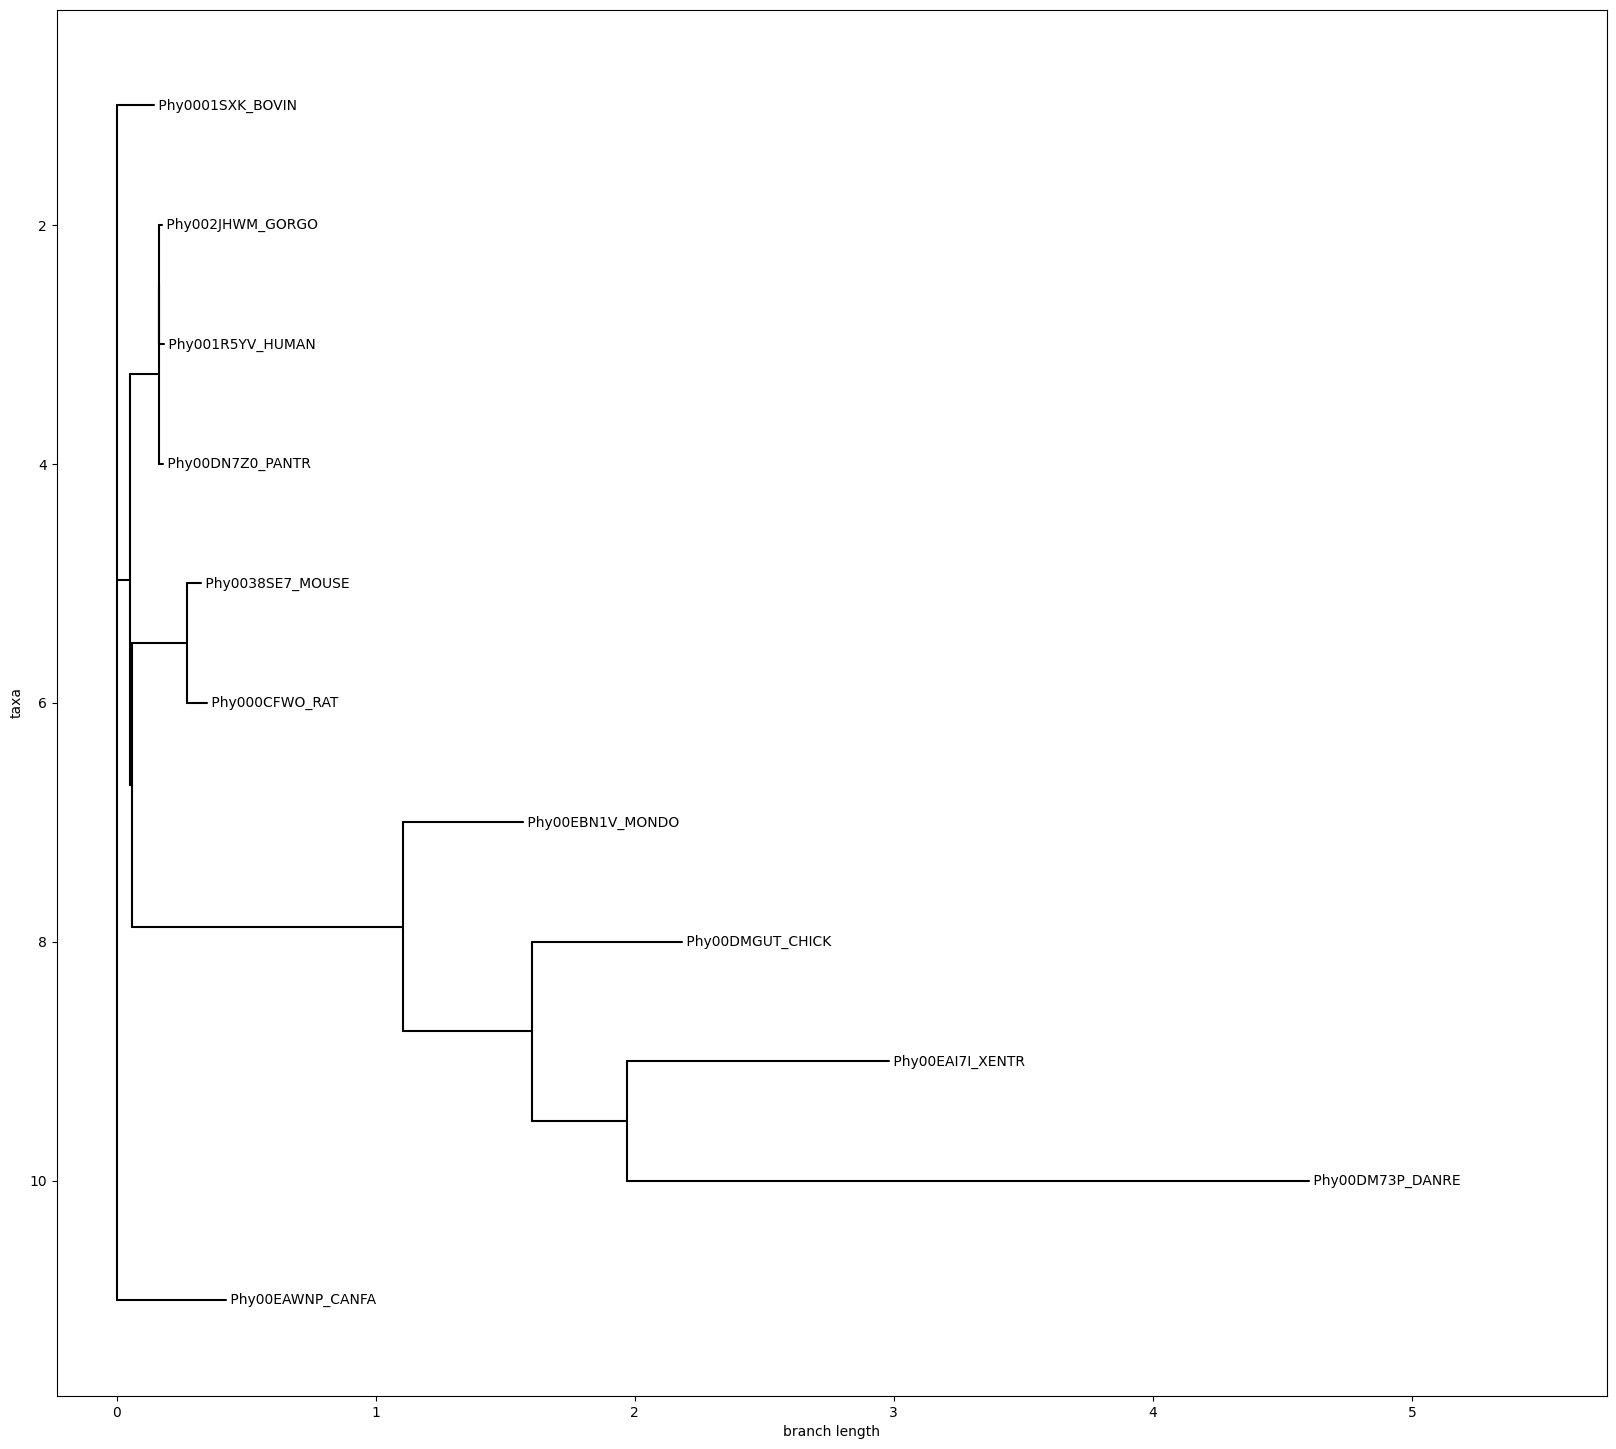

In [56]:
# directory_of_tsv = r'C:\Users\alfonsorodrr\OneDrive - FUJITSU\Escritorio\FUJITSU\Softwares\ncbi-blast-2.12.0+\databases\Miranda\Schpo 25-30'
directory_of_tsv = r'C:\Users\alfonsorodrr\OneDrive - FUJITSU\Escritorio\FUJITSU\Github\Folders\New_benchmarking\Bos_taurus\Selection branches'
file_real_trees = r'C:\Users\alfonsorodrr\OneDrive - FUJITSU\Escritorio\FUJITSU\Github\Folders\New_benchmarking\Bos_taurus\Trees\Bos_taurus.xlsx'


# percentages_list = np.linspace(0,95,5) 
# filter_list = [0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95]
# filter_list = [0.20, 0.30, 0.40, 0.50, 0.60, 0.70]
# del_list = [0.7]



# 
# 

# 
# 

# 
# 


input_file = '0-4064_Phy0001SXK_BOVIN_nd.tsv'
species_name = input_file.replace(".tsv", "")

input_file_name = input_file.replace(".tsv", "")

# nodes, bitscore_matrix = import_from_tsv(directory_of_tsv + '\\' + input_file)
# bitscore_inverse = 100 - bitscore_matrix
# result, annealer_times = assign_key(input_file_name, nodes, bitscore_inverse, 0.4, 0.7, prints=False)
# swapped_result =  {value[::-1]: [str(key)] for key, value in result.items()}

# newick_reconstructed = dict_to_newick(swapped_result, branch_length=1.0)
# visualize(newick_reconstructed, '0-2250_Phy0007XGT_HUMAN_nd_reconstructed.png')

real_tree_lists = import_real_tree(file_real_trees)
# species = re.sub(r'^\d+_', '', input_file_name)
species = re.sub(r'^[^_]+_|_[^_]+$', '', input_file_name)
species_list = [sp[0] for sp in real_tree_lists]
index_tree = species_list.index(species)
newick_real = prune(real_tree_lists[index_tree][3])

visualize(newick_real, '0-4064_Phy0001SXK_BOVIN_nd_real.png')

# branch_length, branch_std = calculate_branch_length(newick_real)

# percentagecd = percentage_cd(newick_real, newick_reconstructed)
# percentagerf = percentage_rf(newick_real, newick_reconstructed, len(nodes))

# print('Percentage CD', percentagecd)
# print('Percentage RF', percentagerf)


In [ ]:
directory_of_tsv = r'C:\Users\alfonsorodrr\OneDrive - FUJITSU\Escritorio\FUJITSU\Softwares\ncbi-blast-2.12.0+\databases\Miranda\Schpo'

# percentages_list = np.linspace(0,95,5)
filter_list = [0]
del_list = [0, 0.6, 0.7, 0.8]

for file in os.listdir(directory_of_tsv):
    input_file = os.fsdecode(file)
    species_name = input_file.replace(".tsv", "")
    if input_file.endswith(".tsv"):

        header = ["", "", 'Del_0', 'Del_60', 'Del_70', 'Del_80']

        with open('all_comm_results.txt', "a") as f:

            f.write(f"Species: {species_name}\n")
            f.write('\t'.join(header) + '\n')

        for perc_filter in filter_list:

            del_results = []
            time_results = []

            for del_comb in del_list:

                print('Species', input_file)
                print('Filter:', perc_filter)
                print('Del:', del_comb)

                start_time = time.time()
                percentage, data_annealers = main_local(directory_of_tsv, input_file, del_filter=perc_filter, del_comb = del_comb, prints=True)
                end_time = time.time()
                
                elapsed_time = end_time - start_time

                del_results.append(percentage)
                time_results.append(elapsed_time)

                # annealer_file_name = input_file.replace(".tsv", "")+ '_DA_times_' + str(int(del_comb*100)) + '_' + str(int(perc_filter*100)) + '.txt'

                # write_annealer_times(annealer_file_name, species_name, data_annealers)

            write_percentages('all_comm_results.txt', perc_filter, del_results, time_results)
            
            print('Percentage_', percentage)


        with open('all_comm_results.txt', "a") as f:

            f.write('-------------------------------------------------------------------\n')

In [ ]:
directory_of_tsv = r'C:\Users\alfonsorodrr\OneDrive - FUJITSU\Escritorio\FUJITSU\Softwares\ncbi-blast-2.12.0+\databases\Miranda\Schpo'
input_file = '14_Phy000D0SO_SCHPO.tsv'

percentage, data_annealers = main_draft(directory_of_tsv, input_file, del_filter=0.40, del_comb = 0.60, prints=True)

In [ ]:
# NEW METHOD

directory_of_tsv = r'C:\Users\alfonsorodrr\OneDrive - FUJITSU\Escritorio\FUJITSU\Softwares\ncbi-blast-2.12.0+\databases\Miranda\Schpo'
input_file = '13_Phy000D0SM_SCHPO.tsv'
print('Species', input_file)
percentage_0, data = main_draft(directory_of_tsv, input_file, del_filter=0, del_comb=0.8, prints=False)
print('Percentage_0', percentage_0)
print('Stored data', data)

# OLD METHOD

# percentage_0_old = old_main_draft(directory_of_tsv, input_file, deletion_perc=0, prints=False)
# print('Percentage_0_old', percentage_0_old)

In [97]:
def old_main_draft(directory, input_file, deletion_perc, prints=False):

    nodes, bitscore_matrix = import_from_tsv(directory + '\\' + input_file)
    bitscore_inverse = 100 - bitscore_matrix
    result = old_assign_key(nodes, bitscore_inverse, deletion_perc, prints=prints)
    swapped_result =  {value[::-1]: [str(key)] for key, value in result.items()}

    # for key in sorted(swapped_result):
    #     print(f"{key}: {swapped_result[key]}")

    newick_reconstructed = dict_to_newick(swapped_result, branch_length=1.0)
    # visualize(newick_reconstructed, 'prueba_reconstructed')

    file_real_trees = r'C:\Users\alfonsorodrr\OneDrive - FUJITSU\Escritorio\FUJITSU\Data_trees\Otros\Schizosaccharomyces_pombe_phylome.xlsx'
    real_tree_lists = import_real_tree(file_real_trees)
    input_file_name = input_file.replace(".tsv", "")
    species = re.sub(r'^\d+_', '', input_file_name)
    species_list = [sp[0] for sp in real_tree_lists]
    index_tree = species_list.index(species)
    newick_real = prune(real_tree_lists[index_tree][3])  

    return(percentage_cd(newick_real, newick_reconstructed))

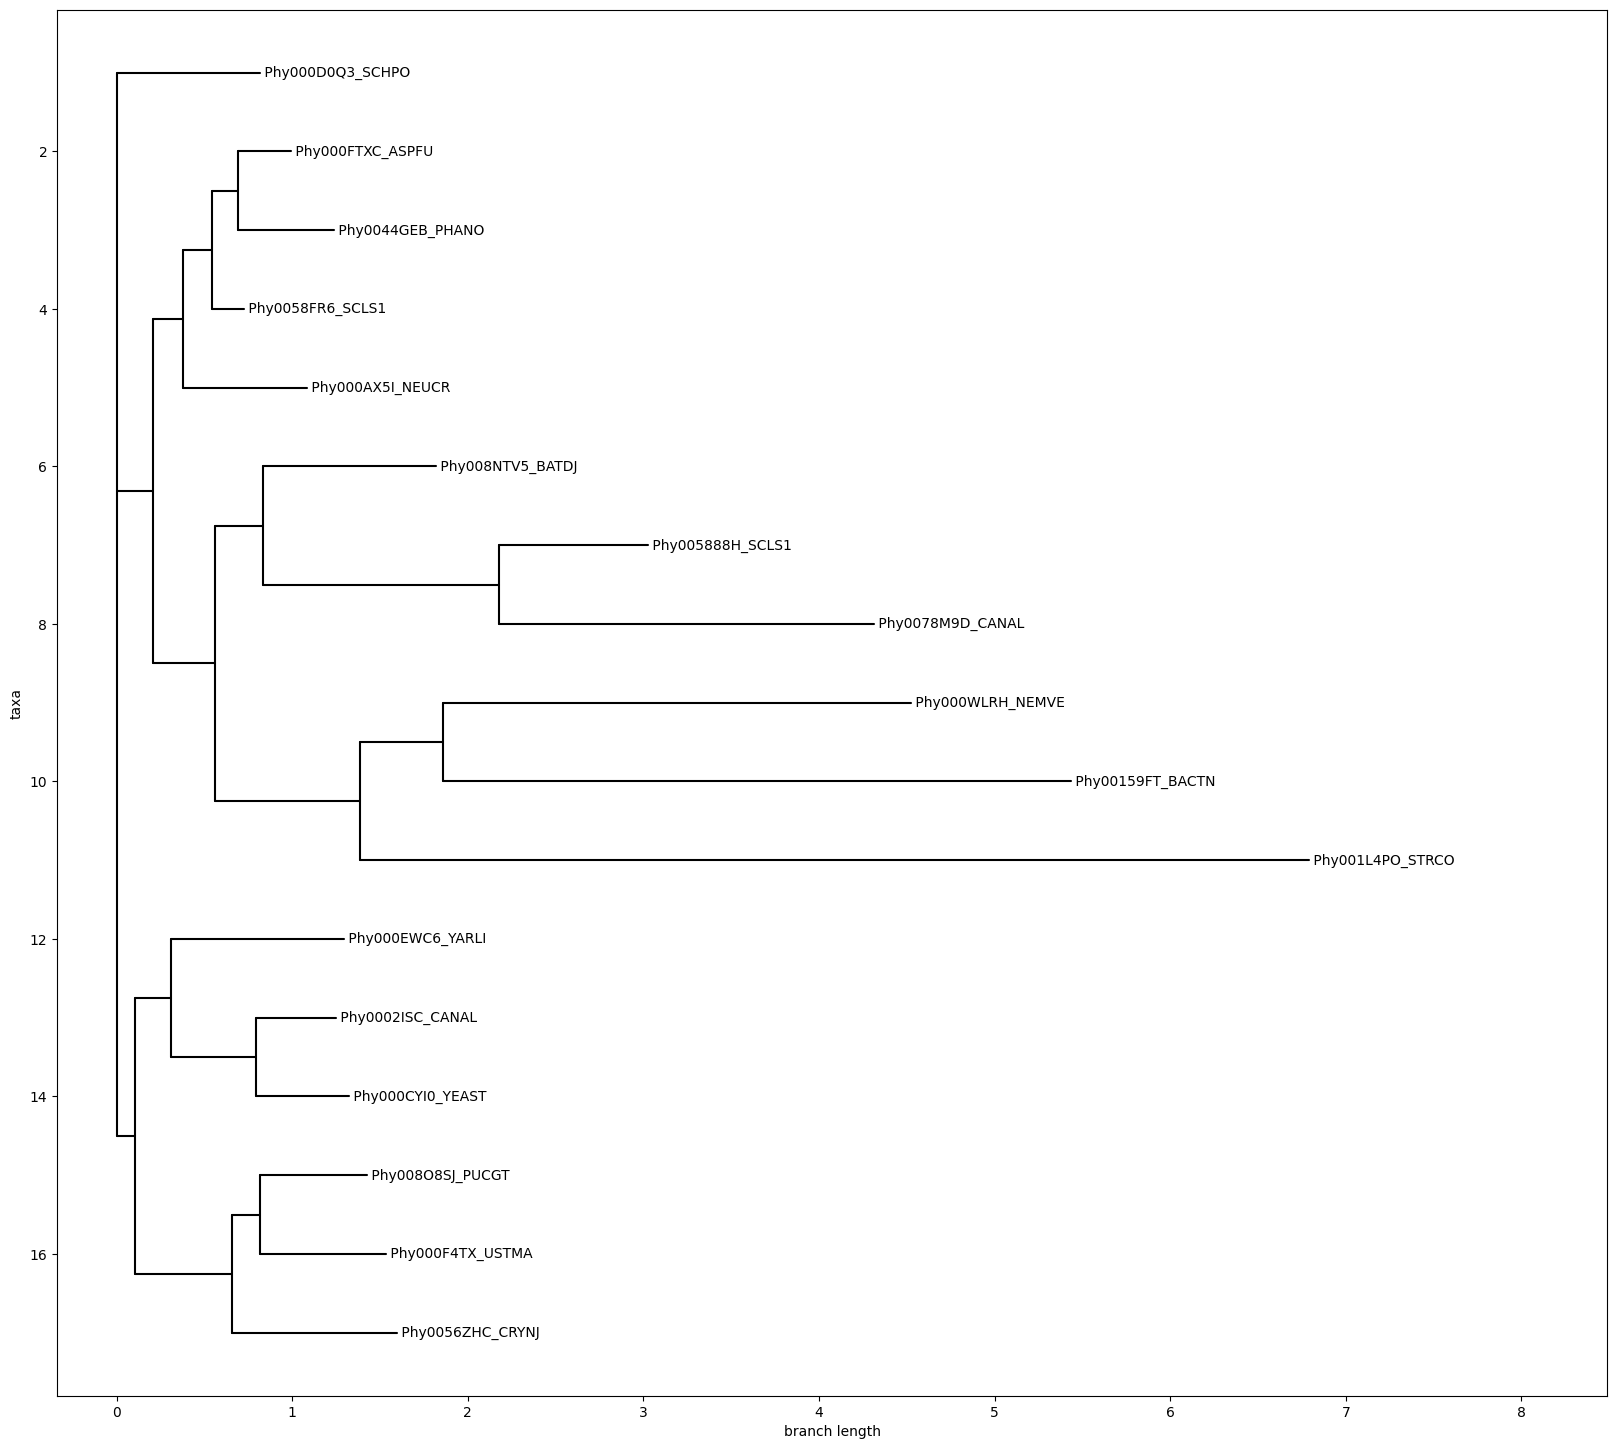

In [43]:
file_real_trees = r'C:\Users\alfonsorodrr\OneDrive - FUJITSU\Escritorio\FUJITSU\Data_trees\Otros\Schizosaccharomyces_pombe_phylome.xlsx'
real_tree_lists = import_real_tree(file_real_trees)
species = 'Phy000D0Q3_SCHPO'
species_list = [sp[0] for sp in real_tree_lists]
index_tree = species_list.index(species)
newick_real = prune(real_tree_lists[index_tree][3])  
visualize(newick_real, '17_Phy000D0Q3_SCHPO_real')

In [58]:
nodes, bitscore_matrix = import_from_tsv(r'C:\Users\alfonsorodrr\OneDrive - FUJITSU\Escritorio\FUJITSU\Softwares\ncbi-blast-2.12.0+\databases\Miranda\Schpo\10_Phy000D0W2_SCHPO.tsv')

bitscore_inverse = 100 - bitscore_matrix
len_nodes = len(nodes)

adj_matrix = calculate_adj_matrix(nodes, bitscore_inverse)
nj_matrix = calculate_nj_matrix(nodes, adj_matrix)

K_vars = len_nodes-1

comms = QUBO_back_func(nodes, nj_matrix, K_vars)

energies = []

for i in range(len(comms)):
    if comms[i][0]<=len_nodes-1 and comms[i][1]<=len_nodes-1:
        index_0 = comms[i][0]
        index_1 = comms[i][1]
        print('indices= (', index_0 ,',', index_1, ')')
        energies.append(nj_matrix[index_0, index_1])
        print(nj_matrix[index_0, index_1])

print('comms', comms)
print('nj_matrix_reals', nj_matrix[:,:len_nodes])

counter = 0
for i in range(len_nodes):
    for j in range(len_nodes):
        if nj_matrix[i,j]>max(energies):
            counter += 1

total = len_nodes*(len_nodes-1)/2

print('above_percentage', counter/total)

indices= ( 1 , 5 )
374.6185398671357
indices= ( 2 , 6 )
465.664085596964
indices= ( 0 , 3 )
482.62473138267273
indices= ( 7 , 8 )
1.0
indices= ( 4 , 9 )
473.27942059213274
comms [[16, 40], [43, 51], [1, 5], [2, 6], [0, 3], [7, 8], [13, 31], [10, 37], [4, 9]]
nj_matrix_reals [[  0.         517.99193398 495.54374168 482.62473138 540.30343684
  527.42100703 523.94936365 598.43960668 596.09737493 506.38492559]
 [  0.           0.         546.37593435 527.71373174 558.99979027
  374.61853987 430.55765457 637.52712317 639.85919592 555.11221787]
 [  0.           0.           0.         537.59247798 507.13730973
  563.47877838 465.6640856  597.64314239 599.03122602 476.28942562]
 [  0.           0.           0.           0.         502.13719456
  509.55933862 542.50853288 576.70671972 576.32914879 533.58424609]
 [  0.           0.           0.           0.           0.
  558.21582624 551.88268475 548.33939459 548.46106419 473.27942059]
 [  0.           0.           0.           0.           0.

In [93]:
nodes, bitscore_matrix = import_from_tsv(r'C:\Users\alfonsorodrr\OneDrive - FUJITSU\Escritorio\FUJITSU\Softwares\ncbi-blast-2.12.0+\databases\Miranda\Schpo\10_Phy000D0W2_SCHPO.tsv')
bitscore_inverse = 100 - bitscore_matrix
result = assign_key(nodes, bitscore_inverse, deletion_perc= 0, prints=None)

indices= ( 0 , 3 )
482.62473138267273
indices= ( 4 , 9 )
473.27942059213274
indices= ( 7 , 8 )
1.0
indices= ( 2 , 6 )
465.664085596964
indices= ( 1 , 5 )
374.6185398671357
comms [[12, 52], [11, 28], [0, 3], [4, 9], [16, 20], [30, 36], [26, 38], [7, 8], [2, 6], [1, 5]]
nj_matrix_reals [[  0.         517.99193398 495.54374168 482.62473138 540.30343684
  527.42100703 523.94936365 598.43960668 596.09737493 506.38492559]
 [  0.           0.         546.37593435 527.71373174 558.99979027
  374.61853987 430.55765457 637.52712317 639.85919592 555.11221787]
 [  0.           0.           0.         537.59247798 507.13730973
  563.47877838 465.6640856  597.64314239 599.03122602 476.28942562]
 [  0.           0.           0.           0.         502.13719456
  509.55933862 542.50853288 576.70671972 576.32914879 533.58424609]
 [  0.           0.           0.           0.           0.
  558.21582624 551.88268475 548.33939459 548.46106419 473.27942059]
 [  0.           0.           0.           0.   

In [103]:
header = ['Species', 'len_nodes', 'perc of deletable combined nodes']

with open("combined_nodes_deletion.txt", "w") as txtfile:
        # Write headers
        txtfile.write('\t'.join(header) + '\n')

In [118]:
nodes, bitscore_matrix = import_from_tsv(r'C:\Users\alfonsorodrr\OneDrive - FUJITSU\Escritorio\FUJITSU\Softwares\ncbi-blast-2.12.0+\databases\Miranda\Schpo\20_Phy000D0XE_SCHPO.tsv')
bitscore_inverse = 100 - bitscore_matrix
result = assign_key(nodes, bitscore_inverse, deletion_perc= 0, prints=None)

indices= ( 10 , 15 )
299.28693711588085
indices= ( 2 , 19 )
499.78384072242557
indices= ( 4 , 5 )
519.3930147710703
indices= ( 7 , 8 )
248.0479097972393
indices= ( 16 , 17 )
310.8354332744584
indices= ( 3 , 18 )
14.380534556834618
indices= ( 11 , 12 )
334.04389122833845
indices= ( 13 , 14 )
1.0
indices= ( 1 , 9 )
297.4209116792158
indices= ( 0 , 6 )
142.58389808139714
comms [[38, 65], [127, 131], [27, 49], [67, 145], [10, 15], [2, 19], [4, 5], [73, 155], [7, 8], [16, 17], [3, 18], [11, 12], [13, 14], [52, 94], [129, 134], [115, 191], [88, 104], [1, 9], [74, 202], [0, 6]]
nj_matrix_reals [[  0.         624.53862322 612.11799939 748.77889754 395.62263236
  539.2053055  142.58389808 776.42764289 737.38989945 610.51653421
  755.80866874 752.73023678 729.25467484 341.33345266 412.78065176
  757.66048032 469.58539866 375.91633702 775.75317698 570.93918642]
 [  0.           0.         555.14859168 668.56226276 593.38386674
  429.06013772 687.65791774 555.79622237 550.1414842  297.42091168
  6

---------
----------

In [ ]:
# we need to use the inverse of the bitscore_matrix
# bitscores indicate how closely related they are, distances indicate how far apart they are

bitscore_inverse = 100 - bitscore_matrix

# we create a dictionary, with one matrix per individual

matrix_dict = {}
nodes = [i for i in range(bitscore_inverse.shape[0])]

# We include the original matrix in the dictionary as node (0,0)
matrix_dict[(0,0)] = bitscore_inverse

for i in range(len(nodes)):
    for j in range(i+1, len(nodes)):
        dist_uk_list = []
        for k in range(len(nodes)):

            if k==i or k==j:
                dist_uk = 1000
                dist_uk_list.append(dist_uk)
            else:
                dist_uk = 0.5*(bitscore_inverse[i][k] + bitscore_inverse[j][k] - bitscore_inverse[i][j])
                dist_uk_list.append(dist_uk)
        
        matrix_dict[(i,j)] = dist_uk_list

for key, value in matrix_dict.items():
    print(key, value)


In [ ]:
# OLD MATRIX, COMPLETE

# We make a N(N+1)/2 x N(N+1)/2 matrix filled with zeros

# adj_matrix = np.zeros((int(len(nodes)*(len(nodes)+1)/2), int(len(nodes)*(len(nodes)+1)/2)))

# for i in range(len(nodes)):
#     for j in range(i+1, len(nodes)):
#         adj_matrix[i,j] = bitscore_inverse[i][j]
#         adj_matrix[j,i] = bitscore_inverse[i][j]
#         n_index = change_index(len(nodes), [i, j])
#         for k in range(len(nodes)):
#             if k==i or k==j:
#                 adj_matrix[n_index,k] = 1000
#                 adj_matrix[k,n_index] = 1000
#             else:
#                 adj_matrix[k,n_index] = 0.5*(bitscore_inverse[i][k] + bitscore_inverse[j][k] - bitscore_inverse[i][j])
#                 adj_matrix[n_index,k] = adj_matrix[k,n_index]
        

# print(adj_matrix)


In [ ]:
# adj_Raquel = np.zeros((len(nodes), 2*len(nodes)))

# for i in range(len(nodes)):
#     for j in range(i+1, 2*len(nodes)):
#         if j < len(nodes):
#             adj_Raquel[i,j] = bitscore_inverse[i][j]
#         else:
#             adj_Raquel[i,j] = 30

In [ ]:
# import numpy as np

# Suppose your matrix is called 'matrix'
# np.savetxt('adj_matrix.txt', adj_matrix, fmt='%.4f')  # '%.4f' formats numbers to 4 decimal places
# np.savetxt('adj_matrix2.txt', adj_matrix2, fmt='%.4f')  # '%.4f' formats numbers to 4 decimal places
# np.savetxt('adj_Raquel.txt', adj_Raquel, fmt='%.4f')
# np.savetxt('nj_matrix.txt', nj_matrix, fmt='%.0f')

In [ ]:
sol = solution_list.min_solution.configuration
for i in range(len(sol)):
    if sol[i]==1:
        print(qqubo.var_shape_set.get_symbolic(i))

In [ ]:
q_dist.get_weights()
solution_list.qubo.var_shape_set.get_symbolic(5)
type(solution_list)

In [ ]:
# change index function test
N = 5

for i in range(N):
    for j in range(i+1,N):
        n_index = change_index(N, [i, j])
        print(f"change_index({i}, {j}) = {n_index}")

for k in range(int(N*(N+1)/2)):
    index_list = change_index(N, [], k)
    print(f"change_index({k}) = {index_list}")

In [ ]:
change_index(17, [5,16])
alg_matrix[15,144]
qqubo.compute(solution_list.min_solution.configuration)
q_dist.compute(solution_list.min_solution.configuration)
H_alpha.compute(solution_list.min_solution.configuration)

In [ ]:
len_nodes = len(nodes)
for i in range(len(comms)):
    if comms[i][0]<=len_nodes-1 and comms[i][1]>len_nodes-1:
        index_coms_1 = comms[i][0]
        index_coms_2 = change_index(len_nodes, [], comms[i][1])[0]
        index_coms_3 = change_index(len_nodes, [], comms[i][1])[1]
        print(nodes[index_coms_1], (nodes[index_coms_2], nodes[index_coms_3]))
        # print([comms[i][0], change_index(len_nodes, [], comms[i][1])])
    elif comms[i][0]>len_nodes-1 and comms[i][1]>len_nodes-1:
        print(change_index(len_nodes, [], comms[i][0]), change_index(len_nodes, [], comms[i][1]))
    elif comms[i][0]<=len_nodes-1 and comms[i][1]<=len_nodes-1:
        index_coms_1 = comms[i][0]
        index_coms_2 = comms[i][1]
        print(nodes[index_coms_1], nodes[index_coms_2])
        # print([comms[i][0], comms[i][1]])

In [ ]:
# PRUEBAS EJEMPLO WIKIPEDIA

prueba_list_step_1 = ['A', 'B', 'C', 'D', 'E']
parejas_step_1 = [['A', 'B']]
bitscore_inverse_step_1 = np.array([[0, 5, 9, 9, 8],
            [5, 0, 10, 10, 9],
            [9, 10, 0, 8, 7], 
            [9, 10, 8, 0, 3], 
            [8, 9, 7, 3, 0]])

prueba_list_step_2 = ['C', 'D', 'E', ['A', 'B']]
parejas_step_2 = [['C', ['A', 'B']]]
bitscore_inverse_step_2 = np.array([[0, 8, 7, 7],
            [8, 0, 3, 7],
            [7, 3, 0, 6], 
            [7, 7, 6, 0]])

prueba_list_step_3 = ['D', 'E', ['C', 'A', 'B']]
parejas_step_3 = [['D', 'E']]
bitscore_inverse_step_3 = np.array([[0, 3, 4],
            [3, 0, 3],
            [4, 3, 0]])
adj_matrix_p = calculate_adj_matrix(prueba_list_step_3, bitscore_inverse_step_3)
removed, added, new_node, new_matrix = update_nodes_adj_matrix(prueba_list_step_3, parejas_step_3, adj_matrix_p)
print(removed)
print(added)
print(new_node)
print(new_matrix)

In [26]:
# PRUEBA 2, FILTER

nodes, bitscore_matrix = import_from_tsv(r'C:\Users\alfonsorodrr\OneDrive - FUJITSU\Escritorio\FUJITSU\Softwares\ncbi-blast-2.12.0+\databases\Miranda\Schpo\17_Phy000D0Q3_SCHPO.tsv')
bitscore_inverse = 100 - bitscore_matrix
result_prueba = assign_key(nodes, bitscore_inverse, result=None)

print(result_prueba)

----------------------------------------
result_before {'Phy0002ISC_CANAL': '', 'Phy000AX5I_NEUCR': '', 'Phy000CYI0_YEAST': '', 'Phy000D0Q3_SCHPO': '', 'Phy000EWC6_YARLI': '', 'Phy000F4TX_USTMA': '', 'Phy000FTXC_ASPFU': '', 'Phy000WLRH_NEMVE': '', 'Phy00159FT_BACTN': '', 'Phy001L4PO_STRCO': '', 'Phy0044GEB_PHANO': '', 'Phy0056ZHC_CRYNJ': '', 'Phy005888H_SCLS1': '', 'Phy0058FR6_SCLS1': '', 'Phy0078M9D_CANAL': '', 'Phy008NTV5_BATDJ': '', 'Phy008O8SJ_PUCGT': ''}
node_list= ['Phy0002ISC_CANAL', 'Phy000AX5I_NEUCR', 'Phy000CYI0_YEAST', 'Phy000D0Q3_SCHPO', 'Phy000EWC6_YARLI', 'Phy000F4TX_USTMA', 'Phy000FTXC_ASPFU', 'Phy000WLRH_NEMVE', 'Phy00159FT_BACTN', 'Phy001L4PO_STRCO', 'Phy0044GEB_PHANO', 'Phy0056ZHC_CRYNJ', 'Phy005888H_SCLS1', 'Phy0058FR6_SCLS1', 'Phy0078M9D_CANAL', 'Phy008NTV5_BATDJ', 'Phy008O8SJ_PUCGT']
len_nodes 17
comms= [[6, 10], [54, 78], [1, 13], [40, 144], [0, 2], [114, 116], [42, 69], [7, 15], [65, 76], [76, 78], [5, 11], [3, 4], [16, 92], [85, 86], [8, 9], [12, 14], [33, 42]]


000: ['Phy000WLRH_NEMVE']
0010: ['Phy00159FT_BACTN']
0011: ['Phy001L4PO_STRCO']
010: ['Phy008NTV5_BATDJ']
0110: ['Phy005888H_SCLS1']
0111: ['Phy0078M9D_CANAL']
100: ['Phy000D0Q3_SCHPO']
10100: ['Phy000FTXC_ASPFU']
10101: ['Phy0044GEB_PHANO']
10110: ['Phy000AX5I_NEUCR']
10111: ['Phy0058FR6_SCLS1']
1100: ['Phy000EWC6_YARLI']
11010: ['Phy0002ISC_CANAL']
11011: ['Phy000CYI0_YEAST']
1110: ['Phy008O8SJ_PUCGT']
11110: ['Phy000F4TX_USTMA']
11111: ['Phy0056ZHC_CRYNJ']


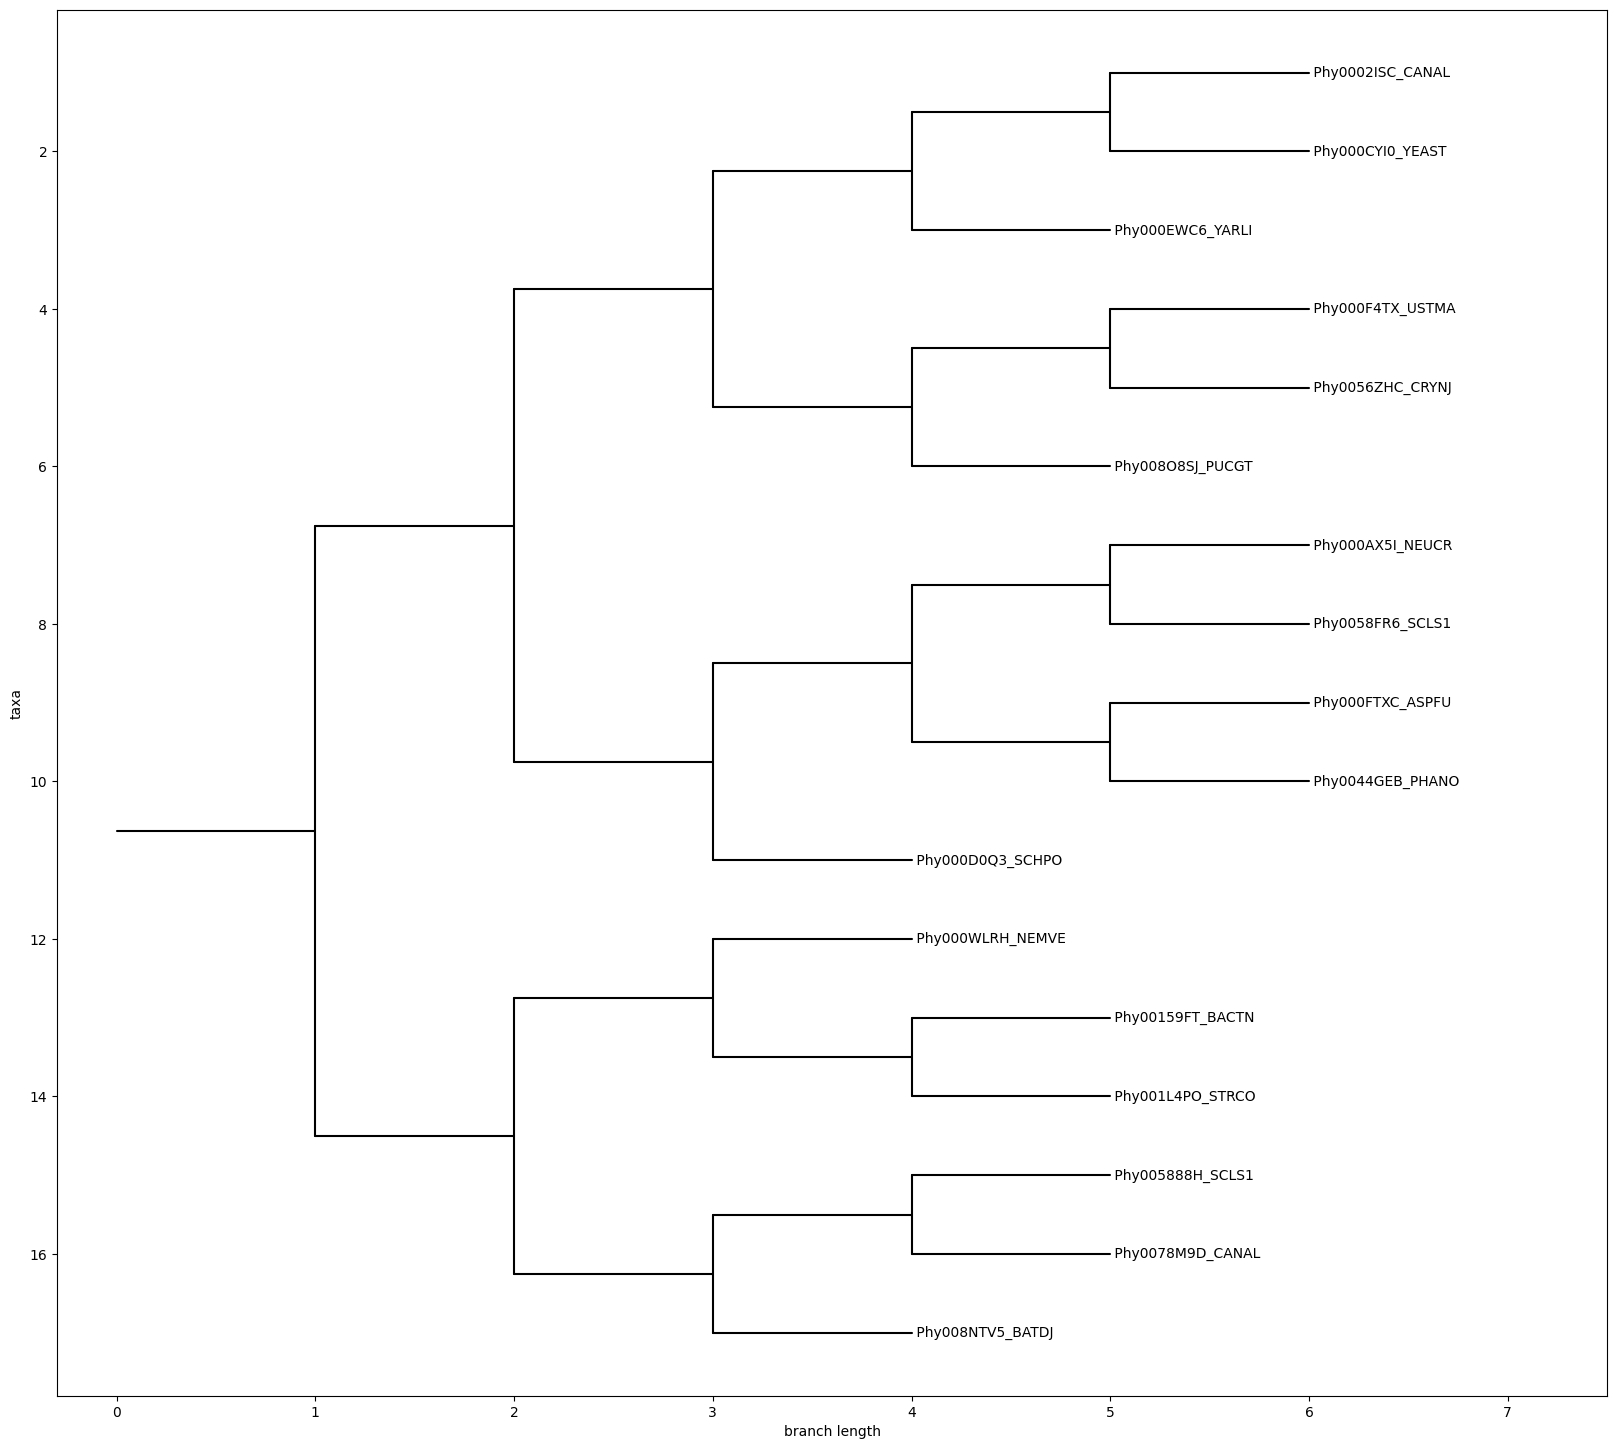

In [36]:
swapped_result =  {value[::-1]: [str(key)] for key, value in result_prueba.items()}

for key in sorted(swapped_result):
    print(f"{key}: {swapped_result[key]}")

newick_prueba = dict_to_newick(swapped_result, branch_length=1.0)
visualize(newick_prueba, '17_reconstructed')

In [37]:
file_real_trees = r'C:\Users\alfonsorodrr\OneDrive - FUJITSU\Escritorio\FUJITSU\Data_trees\Otros\Schizosaccharomyces_pombe_phylome.xlsx'
real_tree_lists = import_real_tree(file_real_trees)
species = 'Phy000D0Q3_SCHPO'
species_list = [sp[0] for sp in real_tree_lists]
index_tree = species_list.index(species)
newick_real = prune(real_tree_lists[index_tree][3])  
print(percentage_cd(newick_real, newick_prueba))

79.99719323670885


In [39]:
# NJ comparison

nj_newick = '((((((((((Phy000FTXC_ASPFU:0.230862296354163,Phy0058FR6_SCLS1:0.184288117488465):0.0129578002042681,Phy0044GEB_PHANO:0.296525656356776):0.0628940199479875,Phy000AX5I_NEUCR:0.381915848354401):0.068474565688958,Phy000D0Q3_SCHPO:0.388087010299641):0.024568052077186,Phy000EWC6_YARLI:0.449062237950253):0.0104738351365815,(Phy0002ISC_CANAL:0.299140266933651,Phy000CYI0_YEAST:0.259210498695186):0.167854687298628):0.047810275885342,(Phy0056ZHC_CRYNJ:0.45279169969586,(Phy000F4TX_USTMA:0.380814715274769,Phy008O8SJ_PUCGT:0.345122288108167):0.0544246862931653):0.0467409762063531):0.0646652569448346,Phy008NTV5_BATDJ:0.328645122520135):0.0542537345226353,(Phy005888H_SCLS1:0.445007857016895,Phy0078M9D_CANAL:0.623145224166506):0.161317149600482):0.0584457236878822,(Phy000WLRH_NEMVE:0.647486377815972,Phy00159FT_BACTN:0.731427876006296):0.0896806465042072,Phy001L4PO_STRCO:0.960712448159708);'
percentage_cd(newick_real, nj_newick)

69.26338057825076

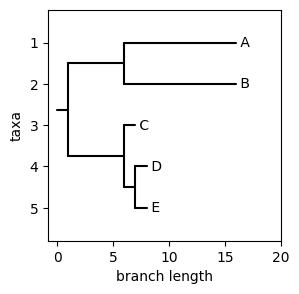

In [36]:
visualize('((A:10, B:10):5, (C:1,(D:1, E:1):1):5):1;', 'borrar', fig_size=(3,3))

In [130]:
import math

# Define the range for the first column
n_taxa = list(range(5, 155, 5))

# Define your personal formulas for the other columns
def calculate_NMCutDA_variables(n_taxa):
    return n_taxa  

def calculate_NJ_variables(n_taxa):
    return int(n_taxa*(n_taxa-1)*(n_taxa+1)/2)  

def calculate_perc_NJ_variables(n_taxa, perc):
    return int((n_taxa-1)*(n_taxa + round((1-perc)*n_taxa*(n_taxa-1)/2)))

def calculate_worst_case_iterations(n_taxa):
    return n_taxa-1  

def calculate_best_case_iterations(n_taxa):
    return int(math.log2(n_taxa))

# Prepare the header and rows
header = ["Number of taxa", "NMCutDA variables", "NJ variables", "worst case iterations", "best case iterations"]
second_header = ["Taxa", "NMCutDA", "NJ", "", "NJ_60", "NJ_70", "NJ_80", "", "worst", "best"]
third_header = ["N", "N", "(N-1)N(N+1)/2", "(N-1)*[N+(1-perc)*N(N-1)/2]", "N-1", "log_2(N)"]
rows = []
for n in n_taxa:
    row = [
        n,
        calculate_NMCutDA_variables(n),
        calculate_NJ_variables(n),
        "",
        calculate_perc_NJ_variables(n, 0.6),
        calculate_perc_NJ_variables(n, 0.7),
        calculate_perc_NJ_variables(n, 0.8),
        "",
        calculate_worst_case_iterations(n),
        calculate_best_case_iterations(n)
    ]
    rows.append(row)

# Write to TXT file with tab separation and aligned columns
with open("resources.txt", "w") as txtfile:
    # Write headers
    txtfile.write('\t'.join(header) + '\n')
    txtfile.write('-'*100 + '\n')
    txtfile.write('\t'.join(second_header) + '\n')
    txtfile.write('\t'.join(third_header) + '\n')
    txtfile.write('-'*100 + '\n')
    # Write rows
    for row in rows:
        txtfile.write('\t'.join(str(item) for item in row) + '\n')

print("Table has been created and saved to 'resources.txt'.")


# Write CSV
# with open("resouces.csv", "w", newline="") as csvfile:
#     writer = csv.writer(csvfile)
#     writer.writerow(header)
#     writer.writerow(second_header)
#     writer.writerow(third_header)

#     writer.writerows(rows)

Table has been created and saved to 'resources.txt'.


#### OLD METHOD

In [47]:
# We make a N(N+1)/2 x N(N+1)/2 matrix filled with zeros

# OLD

def old_calculate_adj_matrix(nodes, bitscore_inverse):

    N = len(nodes)
    adj_matrix = np.zeros((N, int(N*(N+1)/2)))

    for i in range(N):
        for j in range(i+1, N):
            adj_matrix[i,j] = bitscore_inverse[i][j]
            adj_matrix[j,i] = adj_matrix[i,j]
            n_index = change_index(N, [i, j])
            for k in range(N):
                adj_matrix[k,n_index] = 0.5*(bitscore_inverse[i][k] + bitscore_inverse[j][k] - bitscore_inverse[i][j])

    return(adj_matrix)

In [48]:
def old_calculate_nj_matrix(nodes, adj_matrix):

    N = len(nodes)
    nj_matrix = np.zeros((len(nodes), int(len(nodes)*(len(nodes)+1)/2)))

    for i in range(N):
        for j in range(i+1, N):
            nj_matrix[i,j] = (N-2)*adj_matrix[i][j] - np.sum(adj_matrix[i,:N]) - np.sum(adj_matrix[j,:N])
            n_index = change_index(N, [i, j])
            for k in range(N):
                if k==i or k==j:
                    nj_matrix[k,n_index] = 1000
                else:
                    # values in columns[i,n_index] and [j,n_index] are zero in the distance matrix
                    # no need to take them out
                    # NUMBER OF NODES GETS REDUCED BY ONE
                    nj_matrix[k,n_index] = (N-3)*adj_matrix[k][n_index] - np.sum(adj_matrix[k,:N]) - np.sum(adj_matrix[:,n_index]) 

                    # correction for combined node
                    nj_matrix[k, n_index] += - adj_matrix[k][n_index] + adj_matrix[k][i] + adj_matrix[k][j]

    # CORRECTION FOR NJ MATRIX
    # We add the minimum value so it does not have negative numbers

    nj_matrix2 = - min(min(row) for row in nj_matrix) + 1 + nj_matrix
    for i in range(N):
        for j in range(N):
            if j<= i:
                nj_matrix2[i][j] = 0

    return(nj_matrix2)

In [104]:
def old_get_communities(A_matrix,K,solution_list):
    """
    Get the communities for the given graph G and number of clusters K.
    """
    communities = [[] for i in range(K)]

    N = A_matrix.shape[0]

    node_list = [i for i in range(int(N*(N+1)/2))]

    # if K == 2:
    #     for i in range(len(solution_list)):
    #         if solution_list[i][0] == 1:
    #             communities[0].append(node_list[i])
    #         else:
    #             communities[1].append(node_list[i])
    # else:

    for i in range(len(solution_list)):
        for k in range(K):
            if solution_list[i][k] == 1:
                communities[k].append(node_list[i])
                
    return communities

In [49]:
nodes, bitscore_matrix = import_from_tsv(r'C:\Users\alfonsorodrr\OneDrive - FUJITSU\Escritorio\FUJITSU\Softwares\ncbi-blast-2.12.0+\databases\Miranda\Schpo\6_Phy000D0PL_SCHPO.tsv')
bitscore_inverse = 100 - bitscore_matrix

nj_prueba = calculate_real_nj(bitscore_inverse)
corrected_nj_prueba = correct_nj(nj_prueba)
comb_index_list = filter_combined_nodes(len(nodes), corrected_nj_prueba)
filtered_adj = calculate_adj_matrix(bitscore_inverse, comb_index_list)
filtered_nj = calculate_combined_nj(nj_prueba, filtered_adj, comb_index_list)

non_filtered_adj = old_calculate_adj_matrix(nodes, bitscore_inverse)
non_filtered_nj = old_calculate_nj_matrix(nodes, non_filtered_adj)

print('list', comb_index_list)
print('filtered_nj', filtered_nj)
print('non_filtered_nj', non_filtered_nj)

TypeError: filter_combined_nodes() missing 1 required positional argument: 'del_comb'

In [50]:
def old_update_nodes_adj_matrix(node_list, combined_nodes_list, adj_matrix):

    # combined_nodes_list == pair_sublist
    
    # Look for the indices to be removed in node_list based on 
    # the pairs formed in the sublist

    # Create an empty array with the indices to be removed
    # and another with the combined node indices to be added
    removed_indices = []
    added_indices = []

    for j in range(len(combined_nodes_list)):
        for i in range(len(node_list)):

            if node_list[i] in combined_nodes_list[j]:
                removed_indices.append(i)

        n_index = change_index(len(node_list), [removed_indices[j*2], removed_indices[j*2+1]])
        added_indices.append(n_index)

    # MATRIX UPDATE

    # We purge all the combined nodes from the matrix
    new_adj_matrix = adj_matrix[:,:len(node_list)]

    # Add the corresponding combined nodes (as columns and as rows)
    for n in range(len(added_indices)):
        current_n_index = added_indices[n]
        new_column = adj_matrix[:, current_n_index].tolist()

        for k in range(len(new_column), new_adj_matrix.shape[0]):
            old_n_index = added_indices[k-len(node_list)]
            real_indices = change_index(len(node_list), [], current_n_index)
            i_index = real_indices[0]
            j_index = real_indices[1]
            dist = 0.5 * (adj_matrix[i_index, old_n_index] + adj_matrix[j_index, old_n_index] - adj_matrix[i_index, j_index])
            new_column.append(dist)
        
        new_adj_matrix = np.column_stack((new_adj_matrix, new_column))
        new_row = new_column + [0]
        new_adj_matrix = np.vstack((new_adj_matrix, new_row))

    # Delete the corresponding real nodes
    new_adj_matrix = np.delete(new_adj_matrix, removed_indices, axis=0)  # rows
    new_adj_matrix = np.delete(new_adj_matrix, removed_indices, axis=1) # columns

    # We create a new node list removing the real nodes that have been paired up
    new_node_list = [x for x in node_list if node_list.index(x) not in removed_indices]

    # We flatten the combined nodes list

    for i in range(len(combined_nodes_list)):
        flattened_sublist = []
        for item in combined_nodes_list[i]:
            if isinstance(item, list):
                flattened_sublist.extend(item)
            else:
                flattened_sublist.append(item)

        new_node_list.append(flattened_sublist)

    return(removed_indices, added_indices, new_node_list, new_adj_matrix)

In [62]:
def old_assign_key(node_list, bitscore_inverse, deletion_perc, result=None, counter=0, prints=False):

    if result is None:
        result = {}
        for i in range(len(node_list)):
            result[node_list[i]] = ''

    counter += 1

    if prints:
        print('----------------------------------------')
        print('result_before', result)
        print('node_list=', node_list)
        print('len_nodes', len(node_list))

    if len(node_list)>1:

        adj_matrix = old_calculate_adj_matrix(node_list, bitscore_inverse)
        nj_matrix = old_calculate_nj_matrix(node_list, adj_matrix)

        if prints:
            print('adj_matrix', adj_matrix)
            print('nj_matrix', nj_matrix)

        K_vars = len(node_list) -1 

        comms = QUBO_back_func(nj_matrix, K_vars, 'lala')[0]

        if prints:
            print('comms=', comms)

        # combined_deletion_percentage(len(node_list), nj_matrix, comms)

        # Condition for the first iteration, we apply a filter

        if counter<=1:
            filtered_comms = filter_comms(len(node_list), comms, nj_matrix, deletion_perc)
            pair_sublist = create_pair_sublist(node_list, filtered_comms)
            
        else:
            pair_sublist = create_pair_sublist(node_list, comms)

        
        if prints:
            print('pair_sublist', pair_sublist)

        # aquí es donde sucede la magia

        for i in range(len(pair_sublist)):
            if isinstance(pair_sublist[i][0], list):
                for j in range(len(pair_sublist[i][0])):
                    result[pair_sublist[i][0][j]] += '0'
            elif isinstance(pair_sublist[i][0], list) == False:
                result[pair_sublist[i][0]] += '0'

            if isinstance(pair_sublist[i][1], list):
                for j in range(len(pair_sublist[i][1])):
                    result[pair_sublist[i][1][j]] += '1'
            elif isinstance(pair_sublist[i][1], list) == False:
                result[pair_sublist[i][1]] += '1'

        removed, added, new_nodes, new_bitscore = old_update_nodes_adj_matrix(node_list, pair_sublist, adj_matrix)
        if prints:
            print('added_indices', removed)

        old_assign_key(new_nodes, new_bitscore, deletion_perc, result, counter, prints)

    return(result)

----------------------------------------
result_before {'Phy0002L8U_CANAL': '', 'Phy00038B0_CAEEL': '', 'Phy0005G0Y_DICDI': '', 'Phy00068W2_DANRE': '', 'Phy000AZLG_NEUCR': '', 'Phy000D0XE_SCHPO': '', 'Phy000EZ4X_YARLI': '', 'Phy000PJDU_DROME': '', 'Phy000TA5I_ANOGA': '', 'Phy000UL9B_THAPS': '', 'Phy000XO65_BRAFL': '', 'Phy000Z5IG_TRICA': '', 'Phy0037UGL_IXOSC': '', 'Phy0044F1I_PHANO': '', 'Phy0058A1I_SCLS1': '', 'Phy006T3GM_LEPOC': '', 'Phy008NSA4_BATDJ': '', 'Phy00DN0BZ_CRYNJ': '', 'Phy00E72SI_ORYLA': '', 'Phy00EBIJH_MONDO': ''}
node_list= ['Phy0002L8U_CANAL', 'Phy00038B0_CAEEL', 'Phy0005G0Y_DICDI', 'Phy00068W2_DANRE', 'Phy000AZLG_NEUCR', 'Phy000D0XE_SCHPO', 'Phy000EZ4X_YARLI', 'Phy000PJDU_DROME', 'Phy000TA5I_ANOGA', 'Phy000UL9B_THAPS', 'Phy000XO65_BRAFL', 'Phy000Z5IG_TRICA', 'Phy0037UGL_IXOSC', 'Phy0044F1I_PHANO', 'Phy0058A1I_SCLS1', 'Phy006T3GM_LEPOC', 'Phy008NSA4_BATDJ', 'Phy00DN0BZ_CRYNJ', 'Phy00E72SI_ORYLA', 'Phy00EBIJH_MONDO']
len_nodes 20
adj_matrix [[ 0.         78.68493151 74

{'Phy0002L8U_CANAL': '0100',
 'Phy00038B0_CAEEL': '00111',
 'Phy0005G0Y_DICDI': '0001',
 'Phy00068W2_DANRE': '1001',
 'Phy000AZLG_NEUCR': '0110',
 'Phy000D0XE_SCHPO': '01111',
 'Phy000EZ4X_YARLI': '1100',
 'Phy000PJDU_DROME': '01011',
 'Phy000TA5I_ANOGA': '11011',
 'Phy000UL9B_THAPS': '10111',
 'Phy000XO65_BRAFL': '00011',
 'Phy000Z5IG_TRICA': '10011',
 'Phy0037UGL_IXOSC': '11111',
 'Phy0044F1I_PHANO': '1110',
 'Phy0058A1I_SCLS1': '0010',
 'Phy006T3GM_LEPOC': '0101',
 'Phy008NSA4_BATDJ': '0000',
 'Phy00DN0BZ_CRYNJ': '1000',
 'Phy00E72SI_ORYLA': '1101',
 'Phy00EBIJH_MONDO': '1010'}

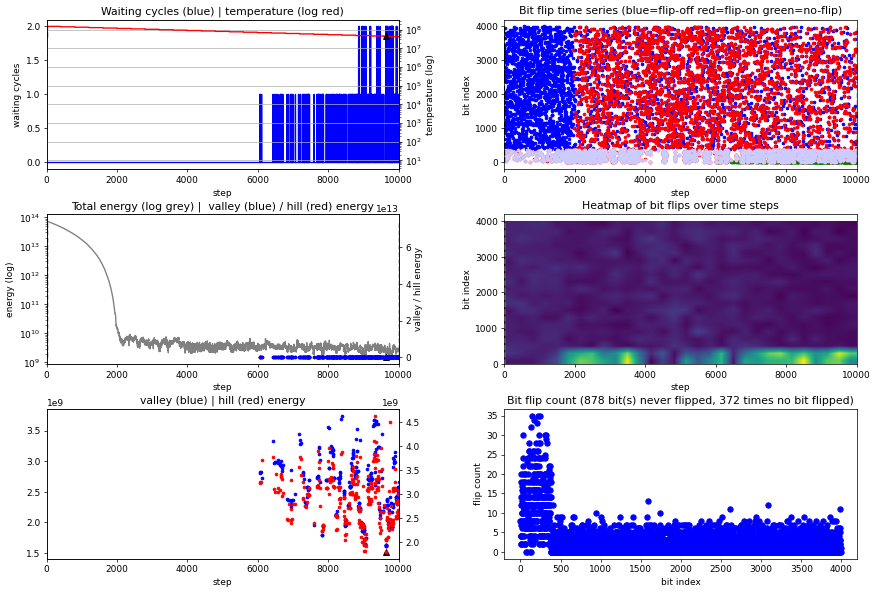

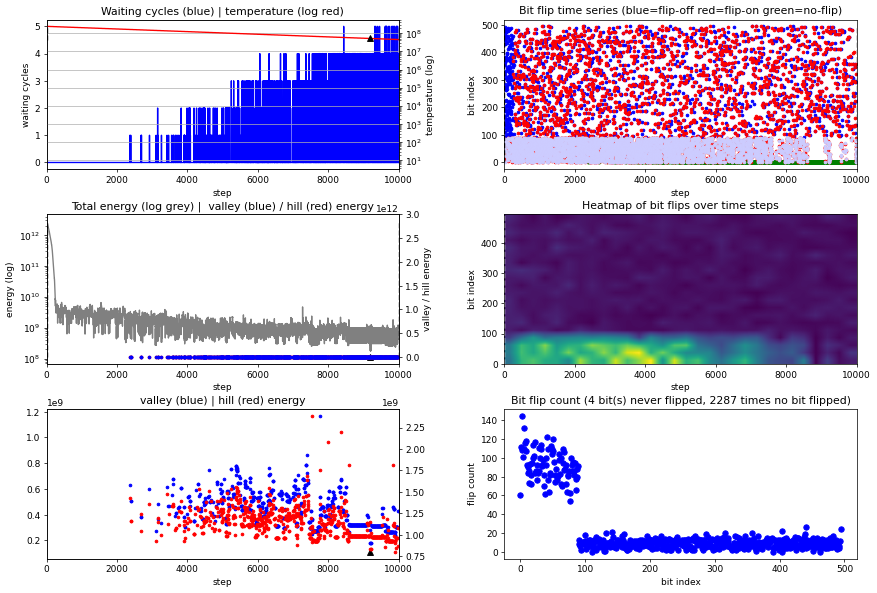

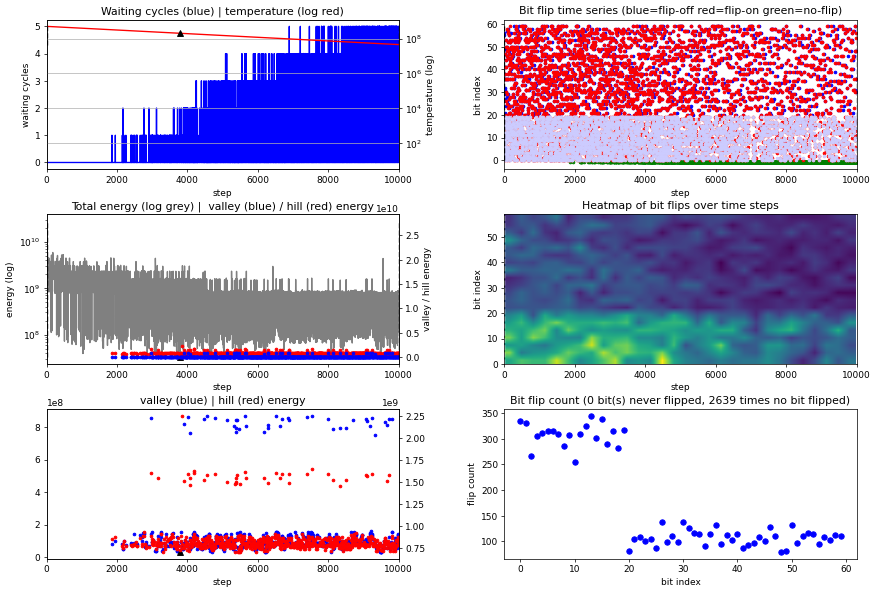

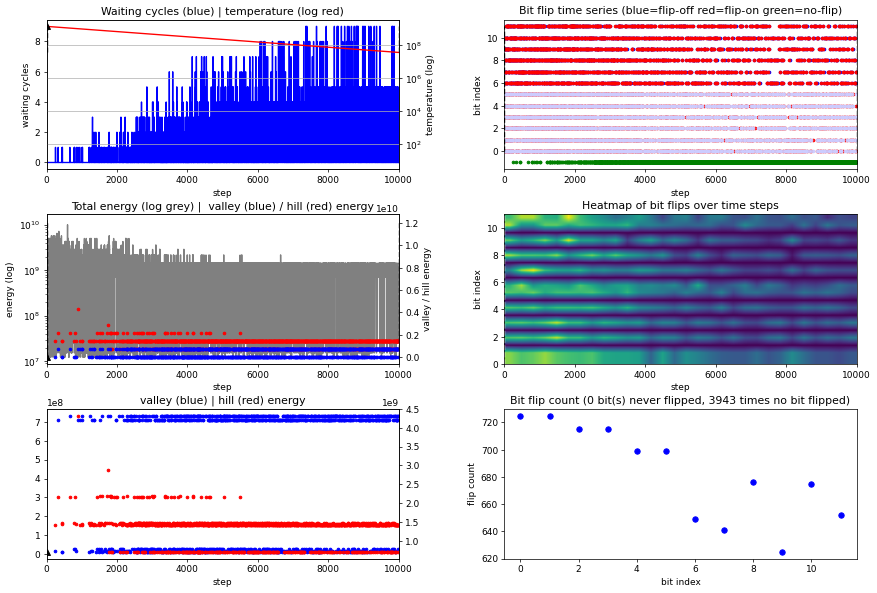

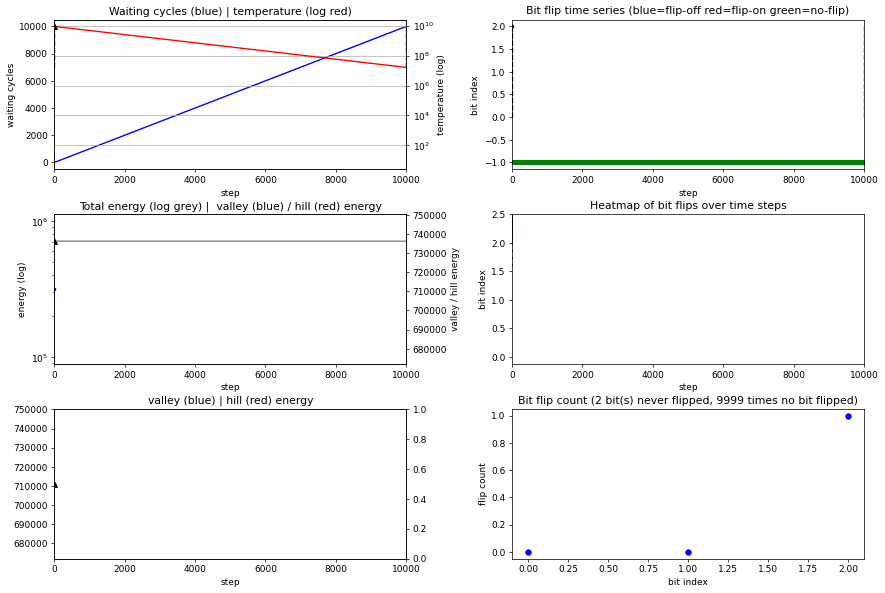

In [105]:
nodes, bitscore_matrix = import_from_tsv(r'C:\Users\alfonsorodrr\OneDrive - FUJITSU\Escritorio\FUJITSU\Softwares\ncbi-blast-2.12.0+\databases\Miranda\Schpo\20_Phy000D0XE_SCHPO.tsv')
bitscore_inverse = 100 - bitscore_matrix
species = '20_Phy000D0XE_SCHPO'

old_assign_key(nodes, bitscore_inverse, 0, prints=True)

In [47]:
import pandas as pd

def save_top_std_perc_by_filter(input_file, output_file, n=10):
    """
    Reads a tab-separated file, groups by 'filter', sorts by 'std_perc' descending,
    and writes the top n rows per filter to a new file (tab-separated).
    """
    # Read the file
    df = pd.read_csv(input_file, sep='\t')
    # Sort and group
    top_by_filter = (
        df.sort_values(['filter', 'std_perc'], ascending=[True, False])
          .groupby('filter', group_keys=False)
          .head(n)
    )
    # Save to output
    top_by_filter.to_csv(output_file, sep='\t', index=False)
    return top_by_filter


In [53]:

my_input_file = r"C:\Users\alfonsorodrr\OneDrive - FUJITSU\Escritorio\FUJITSU\QCare - Árboles filogenéticos\Github\Folders\New_benchmarking\Non-aggregated results\Schizosaccharomyces_pombe_all_NJDA.txt"
my_output_file = r"C:\Users\alfonsorodrr\OneDrive - FUJITSU\Escritorio\FUJITSU\QCare - Árboles filogenéticos\Github\Folders\New_benchmarking\Annealer results\Schizosaccharomyces_pombe_top10_std_perc_by_filter.txt"
save_top_std_perc_by_filter(my_input_file, my_output_file, n=10)

,species,av_branch,std_branch,nodes,filter,av_perc,std_perc
420,0-8481_Phy000D1M1_SCHPO_nd,0.8481,1.0135,32,20,62.3639,11.2409
558,1-0701_Phy000D2U4_SCHPO_nd,1.0701,1.1832,38,20,60.4547,11.2055
564,1-0776_Phy000D28S_SCHPO_nd,1.0776,0.9997,11,20,59.9309,10.3395
312,0-6571_Phy000D0VJ_SCHPO_nd,0.6571,0.7332,40,20,55.4844,9.9837
210,0-4978_Phy000D0YK_SCHPO_nd,0.4978,0.5787,39,20,50.6582,9.5756
264,0-5699_Phy000D0W7_SCHPO_nd,0.5699,0.4688,11,20,53.8046,8.6926
402,0-8116_Phy000D1KD_SCHPO_nd,0.8116,0.9494,40,20,46.9363,8.6753
600,1-1259_Phy000D3F9_SCHPO_nd,1.1259,0.9427,12,20,64.2329,8.3462
396,0-8102_Phy000D104_SCHPO_nd,0.8102,1.5161,28,20,47.6856,8.1604
96,0-2993_Phy000D1TD_SCHPO_nd,0.2993,0.3830,35,20,61.4165,7.7558


In [19]:
import pandas as pd
import numpy as np
from scipy.stats import linregress

def regression_by_species(input_file, output_file):
    """
    For each species in the input file, performs a linear regression of std_perc vs filter,
    and writes a file with columns: species, av_branch, std_branch, nodes, slope, unc_slope.
    """
    # Read the file (tab-separated)
    df = pd.read_csv(input_file, sep='\t')
    results = []

    for species, group in df.groupby('species'):
        # Ensure sorted by filter
        group = group.sort_values('filter')
        x = group['filter'].values
        y = group['std_perc'].values

        # Only regress if at least 2 points
        if len(x) < 2:
            continue

        # Linear regression
        reg = linregress(x, y)
        slope = reg.slope
        unc_slope = reg.stderr

        # Use the first row for static info
        first = group.iloc[0]
        results.append({
            'species': species,
            'av_branch': first['av_branch'],
            'std_branch': first['std_branch'],
            'nodes': first['nodes'],
            'slope': slope,
            'unc_slope': unc_slope
        })

    # Save results
    out_df = pd.DataFrame(results)
    out_df.to_csv(output_file, sep='\t', index=False)
    return out_df



In [ ]:
input_file = r"C:\Users\alfonsorodrr\OneDrive - FUJITSU\Escritorio\FUJITSU\QCare - Árboles filogenéticos\Github\Folders\New_benchmarking\Non-aggregated results\ALL_NJDA.txt"
output_file = r"C:\Users\alfonsorodrr\OneDrive - FUJITSU\Escritorio\FUJITSU\QCare - Árboles filogenéticos\Github\Folders\New_benchmarking\Annealer results\ALL_linear_regression.txt"

regression_by_species(input_file, output_file)

,species,av_branch,std_branch,nodes,slope,unc_slope
0,0-0198_Phy0001SUE_BOVIN_nd,0.0198,0.0378,13,0.063776,0.052181
1,0-0362_Phy0001TF0_BOVIN_nd,0.0362,0.0389,13,-0.119227,0.078662
2,0-0393_Phy0001T23_BOVIN_nd,0.0393,0.0504,13,0.009518,0.057504
3,0-0394_Phy0001SQ8_BOVIN_nd,0.0394,0.0518,11,-0.046420,0.048601
4,0-0451_Phy0001T03_BOVIN_nd,0.0451,0.0544,14,0.037726,0.028157
...,...,...,...,...,...,...
128,2-0593_Phy0001YCX_BOVIN_nd,2.0593,3.7435,36,0.007652,0.014173
129,2-1864_Phy001QCU3_BOVIN_nd,2.1864,4.2331,14,0.001917,0.010850
130,2-3466_Phy00EB78E_BOVIN_nd,2.3466,3.0634,14,-0.082990,0.047914
131,2-5618_Phy00693C3_BOVIN_nd,2.5618,3.6640,11,0.000000,0.000000


In [28]:
input_file = r"C:\Users\alfonsorodrr\OneDrive - FUJITSU\Escritorio\FUJITSU\QCare - Árboles filogenéticos\Github\Folders\New_benchmarking\Annealer results\ALL_linear_regression.txt"
df = pd.read_csv(input_file, sep='\t')
slopes = df['slope'].values
counter = [1 for i in slopes if i<0]
slope_count = sum(counter)
print(slope_count)
print(len(slopes))
print(slope_count/len(slopes))
print(np.mean(slopes))

292
455
0.6417582417582418
-0.027580187127158536


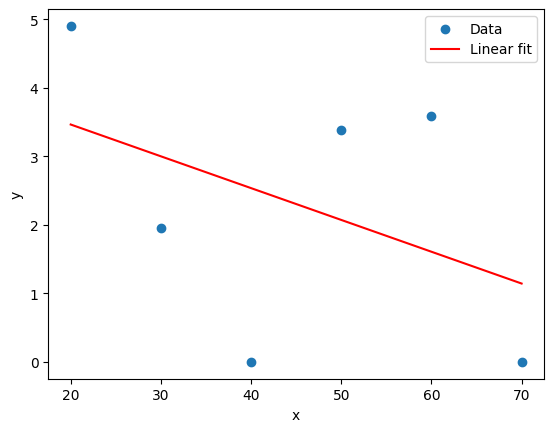

In [112]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

x = np.array([20,30,40,50,60,70])
y = np.array([4.9038, 1.9538, 0, 3.3872, 3.5821, 0])

# Linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)
y_fit = slope * x + intercept

# Plot data and regression line
plt.scatter(x, y, label='Data')
plt.plot(x, y_fit, color='red', label='Linear fit')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [3]:
def resources(N):
    return (3*N/4)*(N+0.2*N*(N-1)/2)

my_list = [5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]

for n in my_list:
    print(int(resources(n)))

26
142
405
870
1593
2632
4042
5880
8201
11062
14520
18630
23448
29032
35437
42720
50936
60142
70395
81750


# D-WAVE

In [44]:
# experimental:start
def as_bqm(self) -> 'dimod.BinaryQuadraticModel':
    """
    The polynomial is returned as a :class:`dimod.BinaryQuadraticModel` object.

    :return: qubo as dimod.BinaryQuadraticModel object
    :rtype: dimod.BinaryQuadraticModel
    """

    try:
        import dimod
    except Exception as oops:
        print('\n\n' + (100 * '#'))
        print('pip install dwave-ocean-sdk')
        print((100 * '#') + '\n\n')
        raise oops

    return dimod.BinaryQuadraticModel(
        {i0: self._p1[i0] for i0 in self._p1},
        {(i0, i1): self._p2[i0][i1] for i0 in self._p2 for i1 in self._p2[i0]},
        self._p0,
        dimod.BINARY)

In [45]:
HQ = BinPol()

HQ.add_term(42.0, (2,3))
HQ.add_term(-1, (1,2))

print(HQ)

- x_1 x_2 + 42.0 x_2 x_3


In [46]:
bqm_problem=HQ.as_bqm()

In [47]:
print(bqm_problem)

BinaryQuadraticModel({2: 0.0, 3: 0.0, 1: 0.0}, {(3, 2): 42.0, (1, 2): -1.0}, 0.0, 'BINARY')


In [48]:
os.environ['DWAVE_API_TOKEN']='Zsos-7d4d4375efae3e72f98e2ab4abc2d127aca9730e'

The one-hot-groups restriction now becomes a penalization term

$$
\sum_{k=1}^K x_{i,k} = 1 \qquad i \in \{1, ..., N\}
$$

$$
\sum_{i=1}^N \left( \sum_{k=1}^K x_{i,k} -1 \right)^2
$$

## Hybrid Solver

In [49]:
from dimod.generators import and_gate
from dwave.system import LeapHybridSampler

In [50]:
def unflatten_solution(flat, n_i, n_k):
    return [flat[i*n_k : (i+1)*n_k] for i in range(n_i)]

In [51]:
def get_qubo_dwave(A_matrix,K_vars, alpha, beta):
    """
    Get the QUBO matrix for the given graph G and number of clusters K.
    """
    fix_varshapeset(A_matrix, K=K_vars)
    
    # Build the QUBO matrix
    qubo = BinPol()
    N = A_matrix.shape[0]
    N_big = A_matrix.shape[1]
    # N_big = 2*N
    for k in range(K_vars):
        for i in range(N):
            for j in range(i+1, N_big):
                qubo.add_term(A_matrix[i,j], ('x', i, k), ('x', j, k)) # d_ij * x_i * x_j
                # if i < N:
                #     qubo.add_term(A_matrix[i,j], ('x', i, k), ('x', j, k)) # d_ij * x_i * x_j
                # elif i >= N and j < N:
                #     qubo.add_term(A_matrix[j,i], ('x', i, k), ('x', j, k))

    q_dist = qubo.clone()

    # build the penalization term 

    H_alpha = BinPol()

    for k in range(K_vars):
        H_aux = BinPol()
        for i in range(N_big):
            H_aux.add_term(1, ('x', i, k))
        H_aux.add_term(-2, ())
        H_aux.power(2)
        H_alpha.add(H_aux)
        
    H_alpha.multiply_scalar(alpha)

    qubo = qubo.add(H_alpha)


    # build the one-hot-groups term as penalization

    H_one_hot = BinPol()

    for i in range(N):
        H_aux = BinPol()
        for k in range(K_vars):
            H_aux.add_term(1, ('x', i, k))
        H_aux.add_term(-1, ())
        H_aux.power(2)
        H_one_hot.add(H_aux)
        
    H_one_hot.multiply_scalar(beta)

    qubo = qubo.add(H_one_hot)


    return(qubo, q_dist, H_alpha, H_one_hot)

In [52]:
def QUBO_dwave(nj_matrix, K_vars):

    alpha = 1000
    beta = 1000

    N = nj_matrix.shape[1]
    
    qubo, q_dist, H_alpha, H_beta = get_qubo_dwave(nj_matrix, K_vars, alpha, beta)

    print('number x_i', N)
    # print('qubo x_i', qubo.var_shape_set.get_symbolic(i))
    print('number x_k = k_vars', K_vars)
    print('total num of variables', qubo.N)


    bqm=qubo.as_bqm()

    sampler = LeapHybridSampler()    
    answer = sampler.sample(bqm)

    best = min(answer.data(['sample', 'energy']), key=lambda d: d.energy)

    # print("Best sample:", best.sample)
    # print("Best energy:", best.energy)

    solution_dwave = list(best.sample.values())

    solution_list_dwave = [int(x) for x in solution_dwave]
    print([qubo.var_shape_set.get_symbolic(i) for i,sol_i in enumerate(solution_list_dwave) if sol_i==1])
    ### comparacion con da ###

    solver_args = {
                    'optimization_method':'annealing',
                    'number_iterations':30000,
                    'number_runs':10,
                    'scaling_bit_precision':32,   ### CAMBIAR AQUI A 32 O 16
                    'scaling_action':ScalingAction.AUTO_SCALING,
                    }
                    # 'graphics':GraphicsDetail.SINGLE

    solver = QUBOSolverCPU(**solver_args)

    solution_list_da = solver.minimize(qubo)

    ##############################
    print('solution_dwave \n', best.sample, best.energy)
    print('solution_list_dwave \n', solution_list_dwave)
    print('variables_dwave', len(solution_dwave))
    print('solution_list_da \n', solution_list_da.min_solution['x'].data)

    unflattened_sol_dwave = unflatten_solution(solution_list_dwave, N, K_vars)

    print('unflatted_sol_dwave \n', np.array(unflattened_sol_dwave))
    print('xk_dwave', len(unflattened_sol_dwave[0]))
    print('xi_dwave', len(unflattened_sol_dwave))

    comms = get_communities(nj_matrix, K_vars, unflattened_sol_dwave) 

    for i in range(len(comms)):
        if len(comms[i]) != 2:
            alpha = alpha*10
            qubo, q_dist, H_alpha, H_beta = get_qubo_dwave(nj_matrix, K_vars, alpha, beta)
            bqm=qubo.as_bqm()
            sampler = LeapHybridSampler()    
            answer = sampler.sample(bqm)
            best = min(answer.data(['sample', 'energy']), key=lambda d: d.energy)
            solution_dwave = list(best.sample.values())
            solution_list_dwave = [int(x) for x in solution_dwave]
            unflattened_sol_dwave = unflatten_solution(solution_list_dwave, N, K_vars)

    
    comms = get_communities(nj_matrix, K_vars, unflattened_sol_dwave) 


    timing_dict = dict(answer.info)


    return(comms, timing_dict, best.energy)

In [109]:
def main_local(directory, input_file, file_real_trees, del_filter, del_comb, prints=False):

    input_file_name = input_file.replace(".tsv", "")

    nodes, bitscore_matrix = import_from_tsv(directory + '\\' + input_file)
    bitscore_inverse = 100 - bitscore_matrix
    result, annealer_times = assign_key(input_file_name, nodes, bitscore_inverse, del_filter, del_comb, prints=prints)
    swapped_result =  {value[::-1]: [str(key)] for key, value in result.items()}

    # for key in sorted(swapped_result):
    #     print(f"{key}: {swapped_result[key]}")

    newick_reconstructed = dict_to_newick(swapped_result, branch_length=1.0)

In [88]:
# ANNEALER MANUAL

species = "0-0198_Phy0001SUE_BOVIN_nd"
filename = species + '_iter1'
directory = r'C:\Users\alfonsorodrr\OneDrive - FUJITSU\Escritorio\FUJITSU\QCare - Árboles filogenéticos\Github\Folders\New_benchmarking\Bos_taurus\Selection branches'
result = None
filtered = True
del_filter = 0.7
old_nodes, bitscore_matrix = import_from_tsv(directory + '\\' + species + '.tsv')
bitscore_inverse = 100 - bitscore_matrix

In [ ]:
old_filename = filename
filename = species + '_iter11'
filtered = False
old_nodes, old_adj_matrix, nj_matrix, comms, pair_sublist, result = load_intermediate_solutions(old_filename + '.json')
removed, added, new_nodes, new_bitscore = update_nodes_adj_matrix(old_nodes, pair_sublist, np.array(old_adj_matrix))

old_nodes = new_nodes
bitscore_inverse = new_bitscore
print(len(new_nodes))

In [56]:
directory_of_tsv = r'C:\Users\alfonsorodrr\OneDrive - FUJITSU\Escritorio\FUJITSU\QCare - Árboles filogenéticos\Nicolás - benchmarking\.tsv\Schizosaccharomyces_pombe'
directory_output = r'C:\Users\alfonsorodrr\OneDrive - FUJITSU\Escritorio\FUJITSU\QCare - Árboles filogenéticos\Nicolás - benchmarking\newick outputs\Schizosaccharomyces_pombe'
os.chdir(directory_output)

# directory = r'C:\Users\alfonsorodrr\OneDrive - FUJITSU\Escritorio\FUJITSU\QCare - Árboles filogenéticos\Nicolás - benchmarking\newick outputs\Bos_taurus'
# input_file = '0-2516_Phy0001SS5_BOVIN_nd.tsv'

for file in os.listdir(directory_of_tsv):
    input_file = os.fsdecode(file)
    if input_file.endswith(".tsv"):

        species = input_file.replace(".tsv", "")
        filename = species + '_iter1'
        filtered = True
        del_filter = 0.8
        old_nodes, bitscore_matrix = import_from_tsv(directory_of_tsv + '\\' + species + '.tsv')
        bitscore_inverse = 100 - bitscore_matrix
        initial_len_nodes = len(old_nodes)
        result = None

        for it in range(1, initial_len_nodes): 

            if result != None:

                old_filename = filename
                filename = species + '_iter' + str(it)
                filtered = False
                old_nodes, old_adj_matrix, nj_matrix, comms, pair_sublist, result = load_intermediate_solutions(old_filename + '.json')
                removed, added, new_nodes, new_bitscore = update_nodes_adj_matrix(old_nodes, pair_sublist, np.array(old_adj_matrix))

                old_nodes = new_nodes
                bitscore_inverse = new_bitscore

            comb_index_list, adj_matrix, nj_matrix = main_calculate_nj(bitscore_inverse, 0.8)

            if len(old_nodes)>=4:
                K_vars = round(len(old_nodes)*3/4)
            elif len(old_nodes)==3:
                K_vars = 2
                filtered = False
            elif len(old_nodes)==2:
                K_vars = 1
            else:
                break

            comms, info_dict, min_energy = QUBO_dwave(nj_matrix, K_vars)
            comms2, an_time2, an_energy2 = QUBO_local(nj_matrix, K_vars, filename)

            # make sure that all comms have len2
            for i in range(len(comms)):
                if len(comms[i])>2:
                    comms[i] = [comms[i][0], comms[i][1]]
                elif len(comms[i])<2:
                    comms[i] = [comms[i][0], len(comms)]

            if result is None:
                    result = {}
                    data = []
                    for i in range(len(old_nodes)):
                        result[old_nodes[i]] = ''

            print('filename', filename)
            print('len_nodes', len(old_nodes))
            print('comms_annealer', comms)
            print('comms_local', comms2)
            print('annealer_times', info_dict)
            print('annealer_energies', min_energy)

            comms1_sorted, energies1_sorted = order_comms(len(old_nodes), comms, nj_matrix)
            comms2_sorted, energies2_sorted = order_comms(len(old_nodes), comms2, nj_matrix)

            print('########## DWAVE ############')
            for i in range(len(comms1_sorted)):
                print(comms1_sorted[i], energies1_sorted[i])

            print('########## LOCAL ############')
            for i in range(len(comms2_sorted)):
                print(comms2_sorted[i], energies2_sorted[i])

            if filtered == True: 
                filtered_comms = filter_comms(len(old_nodes), comms, nj_matrix, del_filter)
                pair_sublist = create_pair_sublist(old_nodes, filtered_comms)
            else:
                pair_sublist = create_pair_sublist(old_nodes, comms)

            for i in range(len(pair_sublist)):
                if isinstance(pair_sublist[i][0], list):
                    for j in range(len(pair_sublist[i][0])):
                        result[pair_sublist[i][0][j]] += '0'
                elif isinstance(pair_sublist[i][0], list) == False:
                    result[pair_sublist[i][0]] += '0'

                if isinstance(pair_sublist[i][1], list):
                    for j in range(len(pair_sublist[i][1])):
                        result[pair_sublist[i][1][j]] += '1'
                elif isinstance(pair_sublist[i][1], list) == False:
                    result[pair_sublist[i][1]] += '1'

            num_variables = K_vars*nj_matrix.shape[1]

            save_intermediate_solutions(filename + '.json', old_nodes, adj_matrix, nj_matrix, comms, pair_sublist, result)
            save_times_energies(filename + '_times_energies.json', len(old_nodes), num_variables, info_dict, min_energy)

        # outside of the loop
        result = load_intermediate_solutions(old_filename + '.json')[5]
        swapped_result =  {value[::-1]: [str(key)] for key, value in result.items()}
        newick_reconstructed = dict_to_newick(swapped_result, branch_length=1.0)

        with open(species + '_tree.txt', 'w') as file:
            file.write(f"{newick_reconstructed}\n")


number x_i 32
number x_k = k_vars 10
total num of variables 320
[('x', 0, 7), ('x', 1, 3), ('x', 2, 7), ('x', 3, 6), ('x', 4, 6), ('x', 5, 4), ('x', 6, 8), ('x', 7, 8), ('x', 8, 4), ('x', 9, 3), ('x', 10, 1), ('x', 11, 0), ('x', 12, 1), ('x', 13, 0), ('x', 19, 9), ('x', 22, 9), ('x', 25, 2), ('x', 29, 2), ('x', 29, 5), ('x', 31, 5)]

********************************************************************************
  temperature_start:                       7.30816572e+02
  temperature_end:                         1.22691322e+02
  offset_increase_rate:                    3.10474874e+02
  duration:                                0.036 sec
********************************************************************************

  max_abs_coefficient:                   5094.425

********************************************************************************
Effective values (including scaling factor)
  scaling_factor:                           4.21493000e+05
  temperature_start:                   

In [95]:
print(answer.info)

{'qpu_access_time': 42743, 'charge_time': 2992697, 'run_time': 2992697, 'problem_id': 'd6a475d4-b1fd-45c1-9e95-6033c717aa7b', 'problem_data_id': '9aee09fa-95ca-4bba-b152-c097fe87e578'}


In [ ]:
print(len(s))

In [ ]:
old_filename = filename

result = load_intermediate_solutions(old_filename + '.json')[5]
swapped_result =  {value[::-1]: [str(key)] for key, value in result.items()}

# for key in sorted(swapped_result):
#     print(f"{key}: {swapped_result[key]}")

newick_reconstructed = dict_to_newick(swapped_result, branch_length=1.0)
# visualize(newick_reconstructed, 'prueba_reconstructed')

file_real_trees = r'C:\Users\alfonsorodrr\OneDrive - FUJITSU\Escritorio\FUJITSU\QCare - Árboles filogenéticos\Github\Folders\New_benchmarking\Bos_taurus\Trees\Bos_taurus.xlsx'
real_tree_lists = import_real_tree(file_real_trees)
species = 'Phy0001SUE_BOVIN'                              # re.sub(r'^\d+_', '', input_file_name)
species_list = [sp[0] for sp in real_tree_lists]
index_tree = species_list.index(species)
newick_real = prune(real_tree_lists[index_tree][3])  

percentage = percentage_cd(newick_real, newick_reconstructed)

print('result', result)
print('percentage', percentage)